# Projet de Data Mining - Spotify

Ce projet s'inscrit dans le cadre de l'UE <i>Data Mining</i>. Il vise à mettre en application les différentes notions de cours abordées, allant de la préparation des données à l'évaluation de modèles prédictifs. <br>Les données ici étudiées sont des données relatives à des musiques, issues du scraping effectué depuis le site <i>Spot On Track</i>.

#### Import des librairies

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl

#### Chargement des données

In [2]:
playlists_df = pd.read_csv('playlists.data', sep="\t")
tracks_df = pd.read_csv('tracks.data', sep="\t")

## 1. Préparation des données

### 1.1 Création de variables

##### Prévisualisation des données

In [3]:
playlists_df.head(5)

,position,title,artists,url,date,playlist
0,1,La marcheuse,Christine and the Queens,https://www.spotontrack.com/track/la-marcheuse...,2018-09-26,fr
1,2,Mojo,Claire Laffut,https://www.spotontrack.com/track/mojo/43473376,2018-09-26,fr
2,3,Julien,Damso,https://www.spotontrack.com/track/julien/41177241,2018-09-26,fr
3,4,Baisers vol\u00e9s,The Pirouettes,https://www.spotontrack.com/track/baisers-vole...,2018-09-26,fr
4,5,\u00c0 la folie - Rework,Juliette Armanet,https://www.spotontrack.com/track/a-la-folie-r...,2018-09-26,fr


Le fichier <i>playlists.data</i>, converti ici en dataframe, décrit la composition des cinq playlists (<i>position</i>, <i>titre</i>, <i>artiste</i>, <i>url</i> et <i>date</i>).

In [4]:
tracks_df.head(5)

,url,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
0,https://www.spotontrack.com/track/eres/42205629,127,C#,Major,80,78,59,0,85,8,5
1,https://www.spotontrack.com/track/rise-dirty-d...,120,C,Major,81,62,71,0,88,6,6
2,https://www.spotontrack.com/track/hipcats/3809...,122,C,Major,88,85,98,0,4,2,6
3,https://www.spotontrack.com/track/the-review/4...,122,G,Major,80,27,66,6,85,7,6
4,https://www.spotontrack.com/track/dre/41836600,123,A#,Minor,73,27,75,0,87,6,4


Le fichier <i>tracks.data</i>, converti ici en dataframe, décrit les chansons qui apparaissent dans les différentes playlists, à l'aide de 10 variables : le <i>BPM</i> (battements par minutes), la <i>Key</i> (tonalité), le <i>Mode</i> (mineur ou majeur), la <i>Danceability</i>, la <i>Valence</i>, l'<i>Energy</i>, l'<i>Acousticness</i>, l'<i>Instrumentalness</i>, la <i>Liveness</i> et enfin la <i>Speechiness</i>. 

##### Vérification de la dimension des données

In [5]:
def data_dimension(dataframe):
    nb_samples, nb_fields = dataframe.shape
    print("{} enregistrements décrits par {} champs : {}".format(nb_samples, nb_fields, ', '.join(list(dataframe.columns))))

In [6]:
data_dimension(tracks_df)

1166 enregistrements décrits par 11 champs : url, BPM, Key, Mode, Danceability, Valence, Energy, Acousticness, Instrumentalness, Liveness, Speechiness


In [7]:
playlist_names = list(playlists_df.playlist.unique())
print(playlists_df.groupby("playlist").size())

playlist
electro    6914
fr         4310
jazz       7606
lovepop    4615
metal      6535
dtype: int64


Seront ici analysées 5 playlists : Electronic Circus (electro), Exception Française (fr), Coffee Table Jazz (jazz), Love Pop (lovepop) et Metal Essentials (metal).

##### Extraction des playlists

<i>
Pour chaque chanson dans une playlist, calculez les nouvelles variables suivantes :

1. la position-pic (meilleure position) obtenue par la chanson dans la playlist,
2. un indicateur binaire qui vaut 1 si la chanson a une position-pic inférieure à 15,
3. la durée pendant laquelle la chanson est apparue dans la playlist (en nombre de semaines),
4. la position moyenne de la chanson dans la playlist (uniquement parmi les semaines où la chanson participe effectivement à la playlist),
5. un indicateur binaire qui vaut 1 si la chanson a une position moyenne inférieure à 15.
</i>

In [8]:
def boolean_adds(df, column_condition, upper_threshold):
    return np.where(df[column_condition] < upper_threshold, 1, 0)

playlists, by_genre = {}, {}
total = pd.DataFrame()

for p in playlist_names:
    by_genre[p] = pd.DataFrame(data = playlists_df.loc[playlists_df['playlist'] == str(p)])

    # Position moyenne de la chanson dans la playlist
    track_grouping = by_genre[p].groupby('title')
    av_position = track_grouping.agg('mean').rename(columns = {'position':('av_position')})
    
    # Durée pendant laquelle la chanson est apparue dans la playlist
    br = track_grouping.size().reset_index(name='broadcasting_time')  
    
    # Position-pic
    subset = by_genre[p].sort_values('position', ascending = True).drop_duplicates(['title'])
    pic_position = by_genre[p][by_genre[p].index.isin(subset.index.tolist())].rename(columns = {'position':('pic_position')}).iloc[:,:2]
    playlists[p] = subset.merge(br, on = "title").merge(pic_position, on = "title").merge(av_position, on = "title")
    
    # Indicateur binaire de la position pic
    playlists[p]['pic_bool'] = boolean_adds(playlists[p], 'pic_position', 15)
    
    # Indicateur binaire de la position moyenne
    playlists[p]['av_bool'] = boolean_adds(playlists[p], 'av_position', 15)
    
    total = total.append(playlists[p])

Les nouvelles variables ont été insérées après la variable <i>playlist</i>, et sont au nombre de 5 : <i>broadcasting_time</i> (durée d'apparition), <i>pic_position</i> (position pic), <i>av_position</i> (position moyenne), <i>pic_bool</i> (indicateur binaire de position pic) et <i>av_bool</i> (indicateur binaire de position moyenne).

### 1.2 Conversion des données
##### Encodage des données

In [9]:
for p in playlist_names:
    playlists[p]['title'] = playlists[p]['title'].apply(str).str.decode('unicode_escape')
    playlists[p]['artists'] = playlists[p]['artists'].apply(str).str.decode('unicode_escape')

## 2. Statistique descriptive

_Pour la playlist de votre choix ou bien la totalité des playlists, réalisez une analyse statistique
descriptive 1D et 2D des chansons décrites par leurs 10 variables (histogrammes, boxplots,
nuages de points...). Commentez les résultats remarquables._

##### Fusion des données (fichiers <i>playlists</i> et <i>tracks</i>)

In [10]:
for p in playlist_names:
    playlists[p] = pd.merge(playlists[p], tracks_df, on='url')

In [11]:
total = pd.merge(total, tracks_df, on='url')

### 2.1 Analyse univariée

In [12]:
%matplotlib inline

##### Résumé numérique général

In [13]:
stat = pd.merge(playlists_df, tracks_df, on='url').drop_duplicates(['url'])
stat.iloc[:,-10:].describe()

,BPM,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
count,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,120.192110,61.076329,36.471698,65.041166,22.904803,38.197256,15.609777,6.494854
std,23.667275,17.037706,22.053205,25.737567,32.970092,39.654307,12.423688,4.736079
min,47.000000,11.000000,0.000000,2.000000,0.000000,0.000000,2.000000,2.000000
25%,107.000000,48.250000,19.000000,50.250000,0.000000,0.000000,9.000000,4.000000
50%,122.000000,64.000000,33.000000,69.000000,3.000000,17.000000,11.000000,5.000000
75%,126.000000,76.000000,51.000000,86.000000,38.000000,85.000000,17.000000,7.000000
max,204.000000,94.000000,97.000000,100.000000,99.000000,96.000000,92.000000,48.000000


Ce résumé numérique nous permettra de situer les chansons jazz vis-à-vis de la tendance générale, dont nous allons ici faire l'analyse univariée.

NB : il est à noter que les chansons doublons ont été supprimées lors de la phase de préparation des données (création de la variable "position-pic"). Bien que les moyennes ici obtenues puissent être légèrement différentes des moyennes d'origine, elles semblent toutefois plus représentatives, chaque chanson figurant en un seul et unique exemplaire.

#### <u> Etude de la playlist jazz</u>

#### 2.1.1 Attributs numériques

In [14]:
def get_numerics(data, playlist):
    return data[playlist].select_dtypes(include=[np.number]).iloc[:,-8:]

In [15]:
numerics_jazz = get_numerics(playlists, 'jazz')

##### Résumé numérique des musique de la playlist 'jazz'

In [16]:
numerics_jazz.describe()

,BPM,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,105.123894,44.000000,17.495575,13.707965,90.513274,61.690265,15.318584,3.946903
std,29.234011,7.997768,9.022911,8.469147,11.221882,32.153671,12.378889,0.962147
min,47.000000,26.000000,0.000000,2.000000,20.000000,0.000000,6.000000,3.000000
25%,87.000000,39.000000,10.000000,7.000000,89.000000,43.000000,10.000000,3.000000
50%,106.000000,43.000000,16.000000,12.000000,93.000000,73.000000,11.000000,4.000000
75%,118.000000,48.000000,23.000000,19.000000,97.000000,88.000000,15.000000,4.000000
max,184.000000,70.000000,47.000000,52.000000,99.000000,96.000000,77.000000,9.000000


Si l'on compare les caractéristiques numériques intrinsèques aux musiques jazz vis-à-vis des autres musiques, on note que :
 * Les musiques jazz enregistrent des moyennes plus basses pour les variables numériques <i>BPM</i>, <i>Danceability</i>, <i>Valence</i> et <i>Energy</i>. Ce sont donc, en moyenne, des musiques de plus faible tempo, moins "positives" et très peu énergiques/intenses ;

* Les musiques jazz sont en moyenne caractérisées par une plus grande acoustique et instrumentalité. Les musiques jazz ont une plus grande accoustique que toutes les autres musiques, car 75% d'entre elles enregistrent un niveau d'accoustique presque trois fois plus haut.


* Parmi toutes les variables, celle liée à la proportion de paroles (speechiness) apparaît comme étant la moins dispersée (écart-type inférieur à 1). On peut donc écrire sans risque que les musiques jazz sont à la quasi-unanimité des musiques sans paroles.

##### Visualisation graphique

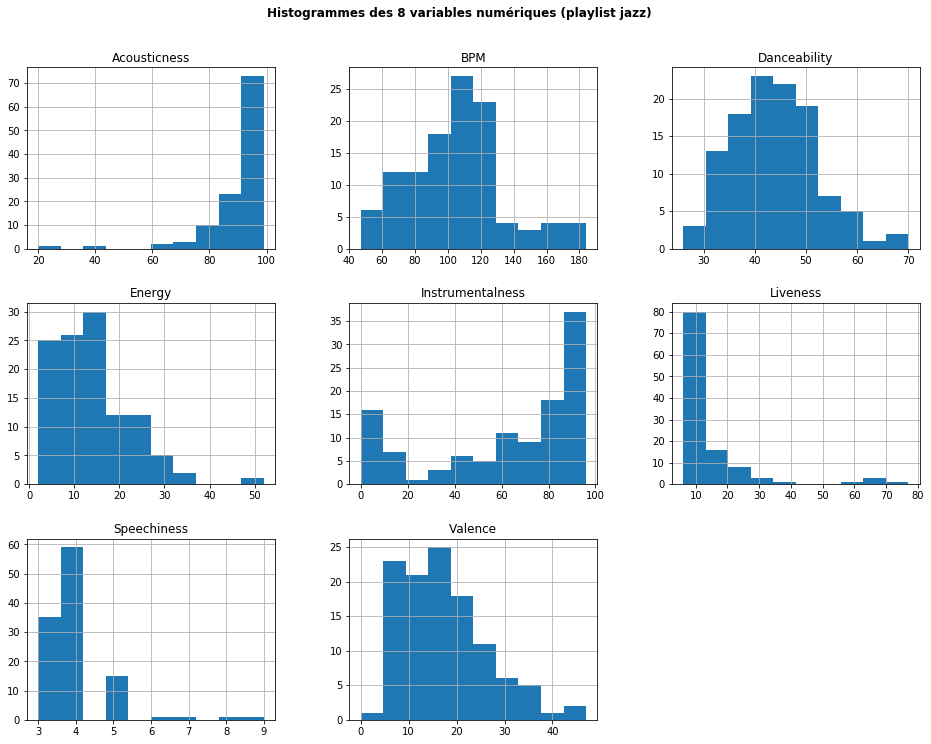

In [17]:
numerics_jazz.hist(figsize=(16,12));
pl.suptitle('Histogrammes des 8 variables numériques (playlist jazz)', y=0.95, weight='bold');

Visuellement, on repère la présence d'outliers ayant des valeurs d'<i>Acousticness</i>, d'<i>Energy</i>, de <i>Liveness</i> et de <i>Speechiness</i> extrêmes. <br/>
On peut aussi noter que les distributions des variables <i>Danceability</i> et dans un second temps <i>BPM</i> s'apparentent à une distribution gaussienne.

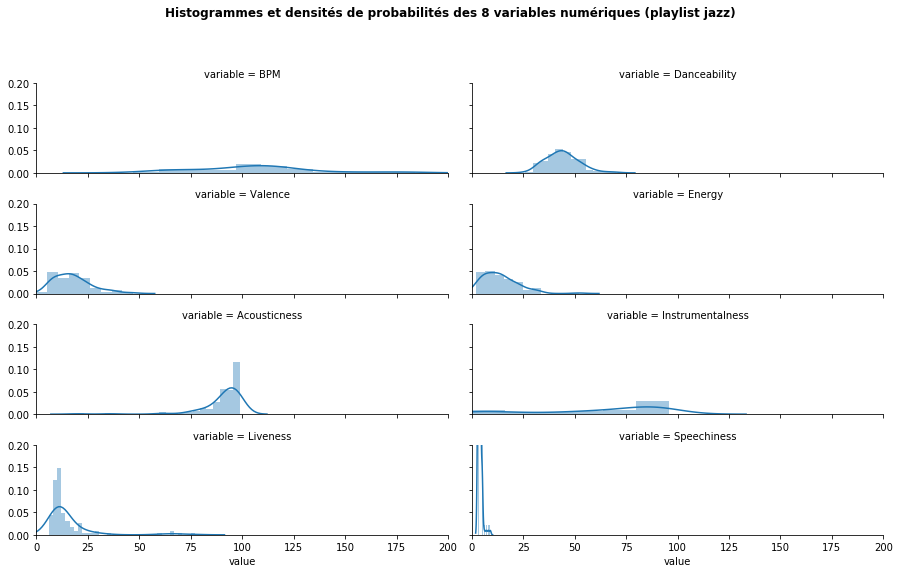

In [18]:
dfm = numerics_jazz.melt(var_name='variable')
g = sns.FacetGrid(dfm, col='variable', col_wrap=2, height=1.8, aspect=3.5, ylim=(0, 0.2), xlim=(0, 200))
g = (g.map(sns.distplot, 'value'))
g.fig.suptitle('Histogrammes et densités de probabilités des 8 variables numériques (playlist jazz)', y=1.1, weight='bold');

Les densités de probabilité ici dessinées confirment ces observations.

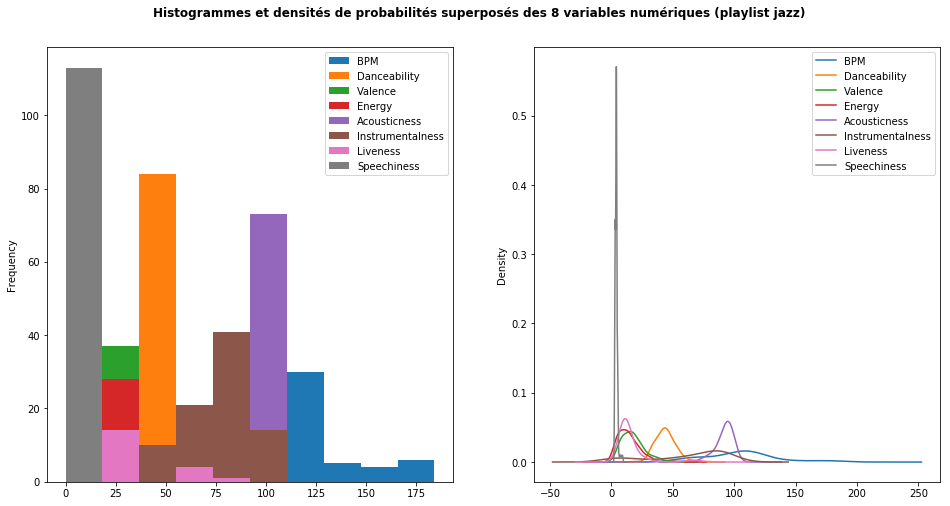

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(16,8))
numerics_jazz.plot(kind="hist", ax=ax[0]);
numerics_jazz.plot(kind="kde", ax=ax[1]);
fig.suptitle('Histogrammes et densités de probabilités superposés des 8 variables numériques (playlist jazz)', y=0.95, weight='bold');

Cette visualisation superposée laisse apparaître que les variables <i>Energy</i> et <i>Valence</i> ont des distributions quasiment analogues. <br>
La variable <i> Speechiness </i> se distingue de toutes les autres, par sa grande densité de probabilité.

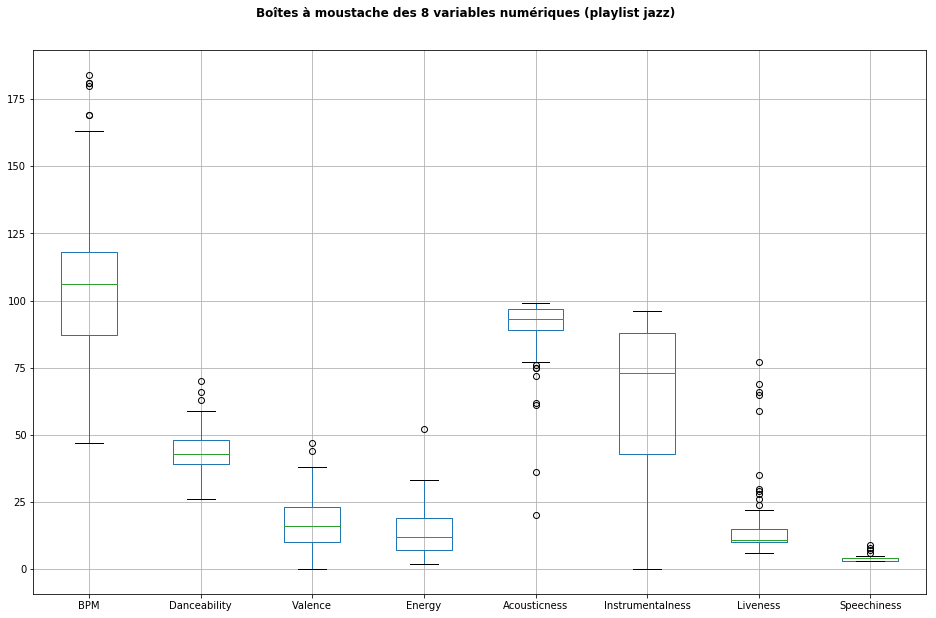

In [20]:
numerics_jazz.boxplot(figsize=(16,10));
pl.suptitle('Boîtes à moustache des 8 variables numériques (playlist jazz)', y=0.94, weight='bold');

Le tracé des boîtes à moustaches révèle :
* Une distribution symétrique pour les variables <i>Danceability</i>, <i>Valence</i> et <i>Energy</i> (moyenne et médiane proches) ;
* La présence de nombreux outliers pour les variables <i>Acousticness</i>, <i>Liveness</i> et <i>Speechiness</i>;
* L'ample étendue de la variable BPM.

#### 2.1.2 Attributs catégoriques

In [21]:
def get_categories(data, playlist):
    return data[playlist].select_dtypes(exclude=[np.number]).iloc[:,-2:]

In [22]:
categories_jazz = get_categories(playlists, 'jazz')

##### Résumé numérique des musiques de la playlist 'jazz'

In [23]:
categories_jazz.describe()

,Key,Mode
count,113,113
unique,12,2
top,C,Major
freq,18,72


##### Résumé numérique général

In [24]:
stat.select_dtypes(exclude='number').iloc[:,-2:].describe()

,Key,Mode
count,1166,1166
unique,12,2
top,D,Major
freq,131,640


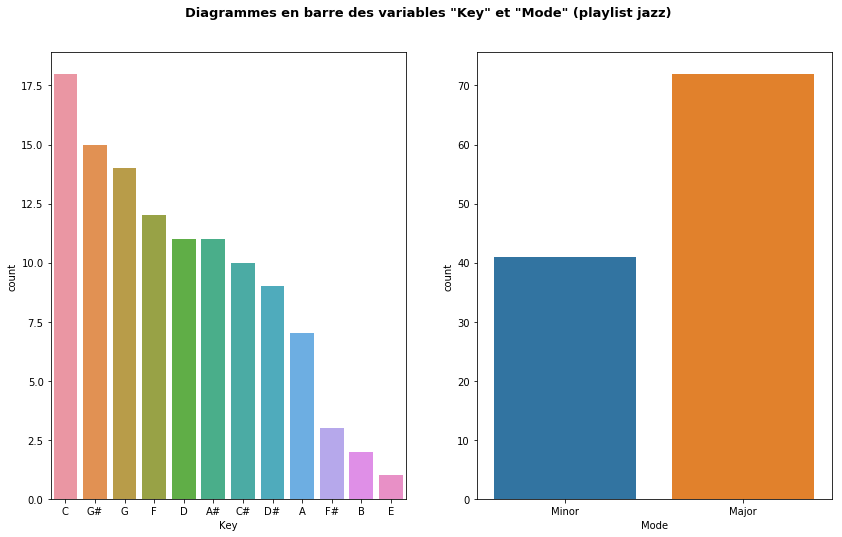

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(14,8))
sns.countplot(categories_jazz['Key'], ax=ax[0], order=categories_jazz['Key'].value_counts().index);
sns.countplot(categories_jazz['Mode'], ax=ax[1]);
fig.subplots_adjust(top=0.9)
fig.suptitle('Diagrammes en barre des variables "Key" et "Mode" (playlist jazz)', fontsize=13, fontweight='bold');

Si les musiques jazz sont en mode majeur comme le sont en moyenne les autres musiques, leur tonalité moyenne diffère (clef en C et non en D).

### 2.2 Analyse bivariée

#### 2.2.1 Attributs numériques

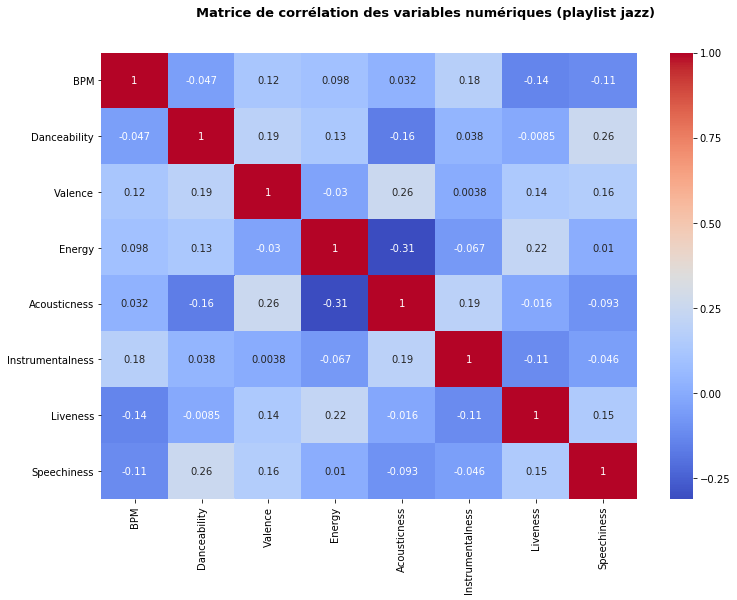

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
hm = sns.heatmap(data=numerics_jazz.corr(), ax=ax, cmap="coolwarm", annot=True)
fig.subplots_adjust(top=0.9)
fig.suptitle('Matrice de corrélation des variables numériques (playlist jazz)', fontsize=13, fontweight='bold');

D'après la matrice dessinée, il semblerait que les variables <i>Acousticness</i> et <i>Energy</i> soient corrélées négativement (-0.31) et les variables <i>Valence</i> et <i>Danceability</i> positivement (0.19), même si dans une moindre mesure. Ces observations sont des tendances de corrélation générale : quelle que soit la playlist, ces variables sont respectivement corrélées négativement et positivement, comme la droite de régression tracée ci-dessous le montre.

In [27]:
from sklearn import linear_model
import matplotlib.ticker as ticker

def plot_linearRegression(v1, v2):
    x = stat.iloc[:,-10:][v1].values
    y = stat.iloc[:,-10:][v2].values 
    x = x.reshape(x.shape[0], 1)
    y = y.reshape(y.shape[0], 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    fig = plt.figure(figsize=(16,8));
    fig.suptitle('Modèle de régression linéaire entre les variables {0} et {1}'.format(v1, v2), y=0.94, fontweight='bold');
    ax = plt.subplot(1, 1, 1)
    ax.scatter(x, y,alpha=0.5)
    ax.plot(x, regr.predict(x), color='red', linewidth=2)
    plt.xticks(())
    plt.yticks(())
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(25))
    plt.xlabel(v1)
    plt.ylabel(v2)
    plt.show()

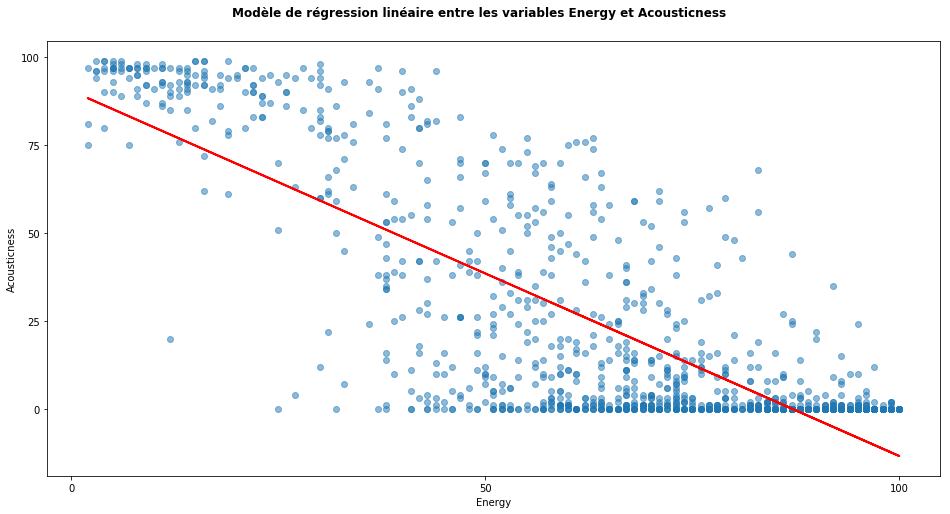

In [28]:
plot_linearRegression('Energy', 'Acousticness')

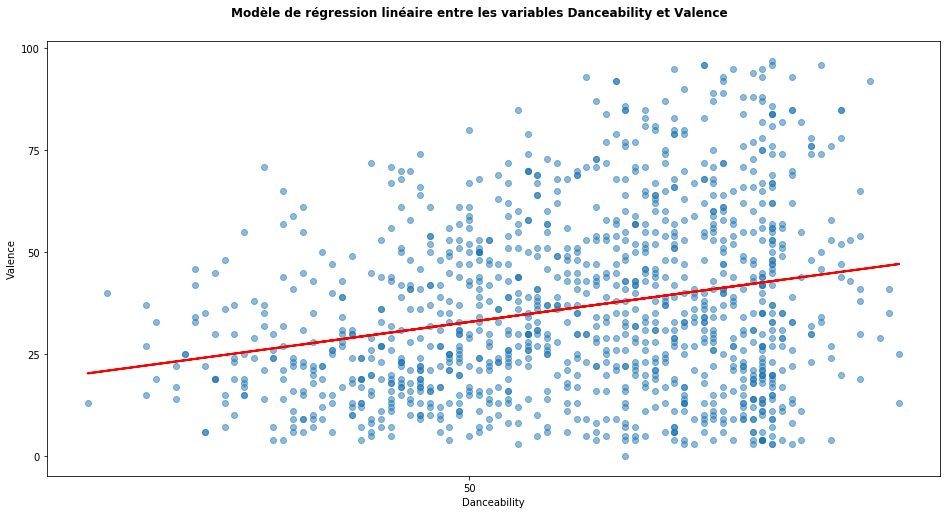

In [29]:
plot_linearRegression('Danceability', 'Valence')

Les observations faites à partir de la matrice de confusion sont ici mis en image, au travers d'une droite de régression.

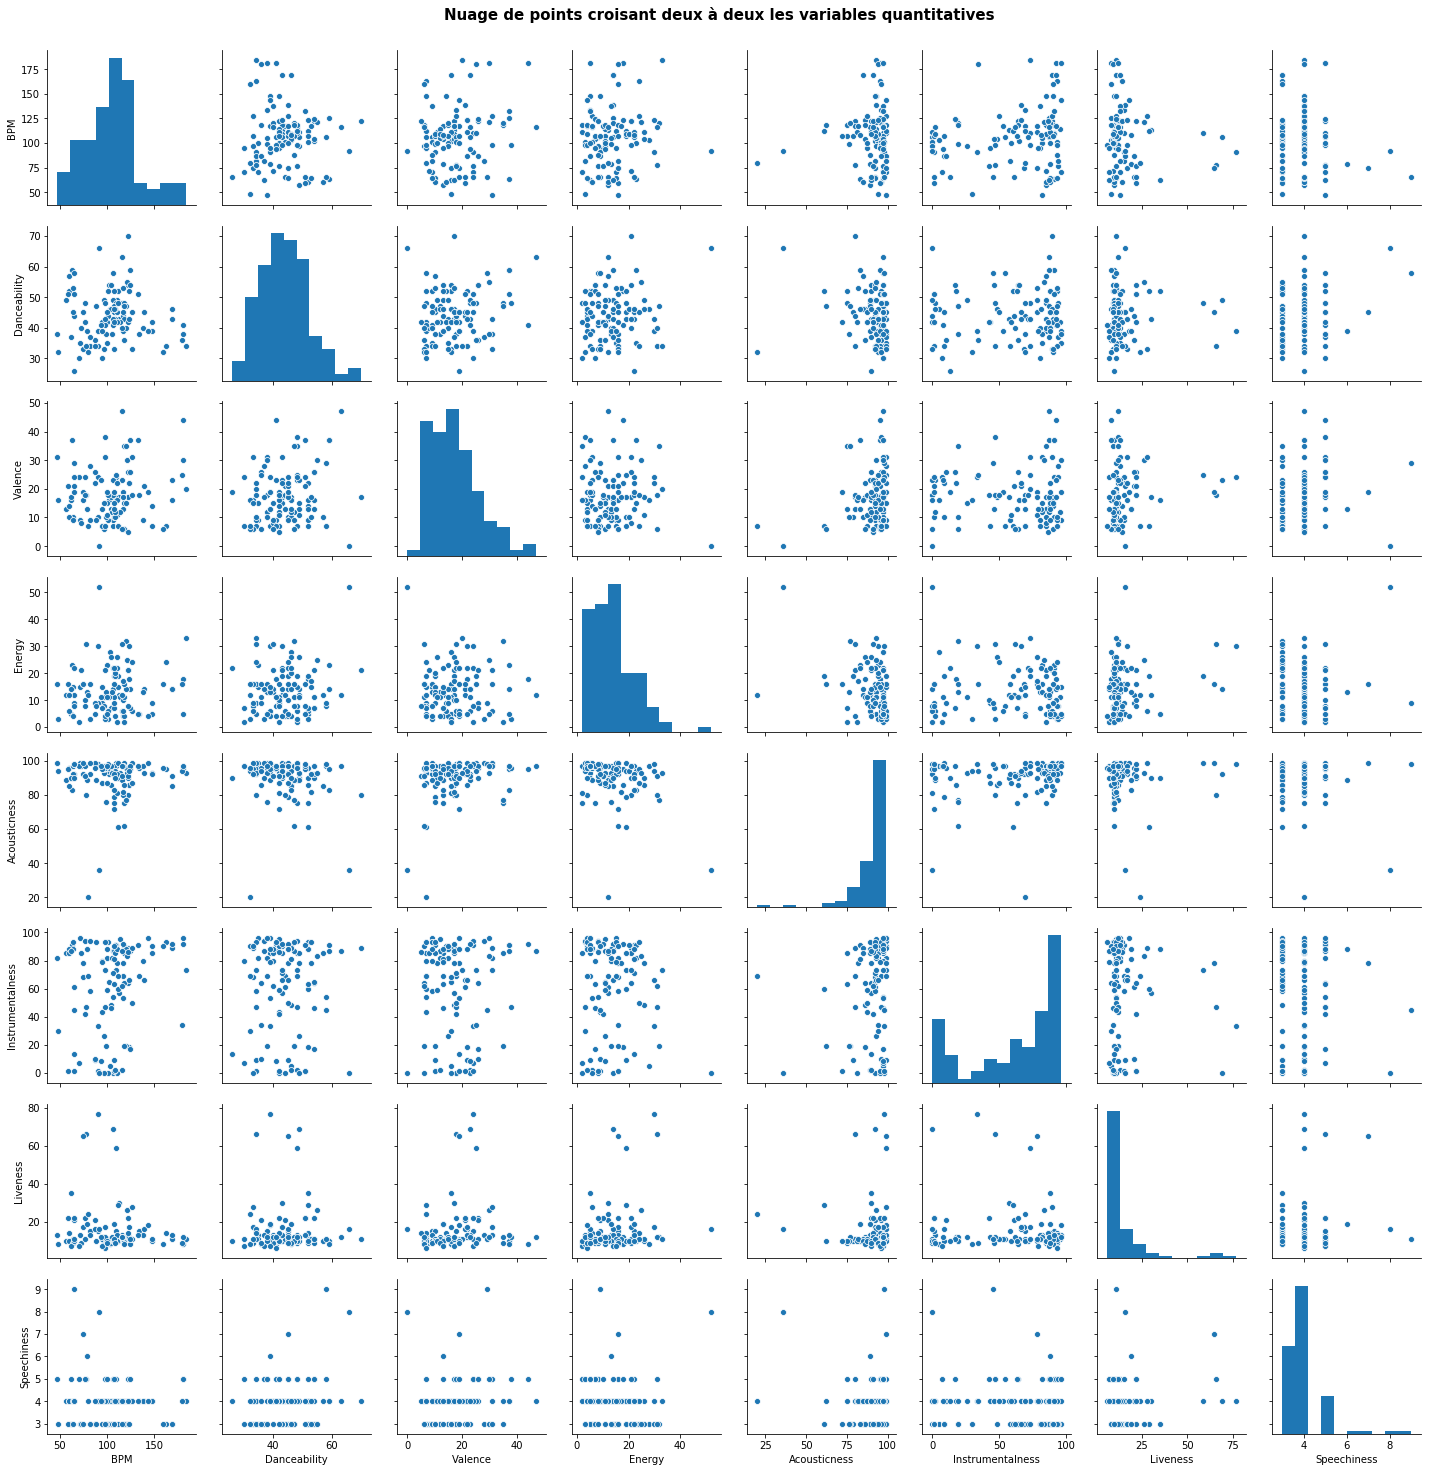

In [30]:
g = sns.pairplot(numerics_jazz);
g.fig.suptitle('Nuage de points croisant deux à deux les variables quantitatives', fontsize=15, fontweight='bold', y=1.02);

On retrouve les observations faites à partir de ce graphique en nuage de points.

#### 2.2.2 Attributs catégoriques

Le test du Khi-deux nous permettra ici de tester si les deux variables catégoriques sont indépendantes ou non.

In [31]:
from scipy.stats import chi2_contingency

<u>Hypothèses :</u>

H0 (hypothèse nulle) : les deux variables sont indépendantes<br>
H1 : les deux variables ne sont pas indépendantes

In [32]:
table = pd.crosstab(categories_jazz['Key'], categories_jazz['Mode'], margins=False)

In [33]:
def test_chi2(table):
    stat, p, dof, expected = chi2_contingency(table)

    H0 = False if p <= 0.05 else True
    relationship = "dépendantes" if not H0 else "indépendantes"
    
    print("D'après les résultats du test du Khi-deux, les variables {} et {} sont {}.".format(table.index.name, table.columns.name, relationship))

In [34]:
test_chi2(table)

D'après les résultats du test du Khi-deux, les variables Key et Mode sont indépendantes.


### 2.3 Profil type moyen d'une chanson, meilleurs ranking et évolution temporelle du ranking

In [35]:
num_vars = ['BPM', 'Danceability', 'Valence', 'Energy', 'Acousticness', 'Instrumentalness', 'Liveness', 'Speechiness']

#### 2.3.1 Profil moyen de la chanson d'une playlist

_Déterminez pour chaque playlist le profil de la chanson moyenne sur les 10 variables, et
identifiez quelques morceaux qui s'en rapprochent le plus possible._

##### Variables numériques

In [36]:
num_means = {}
for p in playlist_names:
    num_means[p] = get_numerics(playlists, p).mean().to_frame().T
    num_means[p].reset_index(drop=True, inplace=True)

##### Variables catégoriques

In [37]:
cat_proportions = {}
for p in playlist_names:
    cat_proportions[p] = get_categories(playlists, p).describe().T['top'].to_frame().T
    cat_proportions[p].reset_index(drop=True, inplace=True)

#### <u>Chansons les plus représentatives de chaque playlist (omission des variables catégoriques)<u>

In [38]:
def global_summary(playlist):
    return playlists[playlist].iloc[:,-10:].describe(include='all').loc[['top', 'mean'],:]

In [39]:
def title_summary(playlist, title):
    return playlists[playlist].loc[playlists[playlist]['title']==title].iloc[:,-10:]

##### Calcul des profils moyens et distances à la moyenne

In [40]:
most_similar = {}
for p in playlist_names:
    distances = scipy.spatial.distance.cdist(num_means[p], playlists[p].select_dtypes(include=[np.number])[num_vars], metric='euclidean')
    distances_df = pd.DataFrame(distances).T
    distances_df.rename(columns={distances_df.columns[0]:'distance'}, inplace=True)
    min_dist = distances_df.nsmallest(3, 'distance').index.tolist()
    most_similar[p] = playlists[p].loc[min_dist][['title', 'artists']]

##### Trois premières chansons les plus représentatives (par playlist)

In [41]:
for p in playlist_names:
    print('\nPlaylist : {}'.format(p))
    for t, a in zip(most_similar[p]['title'], most_similar[p]['artists']):
        print('{} de {}'.format(t, a))


Playlist : fr
Mojo de Claire Laffut
Au sud de la banlieue nord de Benjamin Paulin
Les filles d'aujourd'hui - Brigitte fontaine de Blondino

Playlist : jazz
Good Morning.Goodbye de Dan Cray Trio
Vid Frösö kyrka (At Frösö Church) - From Frösöblomster (Frösö Flowers) (arr. J. Ekberg, P.V. Johansson and L. Simonsson) de Trio X of Sweden
After All de Joost Lijbaart, Yuri Honing Acoustic Quartet, Gulli Gudmundsson, Wolfert Brederode

Playlist : lovepop
imagine de Ariana Grande
Can I Be Him de James Arthur
For The Love de Hearts & Colors

Playlist : electro
Rising de Jiggler
Belize de Anja Schneider
Bamboo de Marcus Meinhardt

Playlist : metal
Chop Suey! de System Of A Down
Adrenalize de In This Moment
Concrete Jungle de Black Label Society


##### Exemple détaillé de la chanson 'Good Morning.Goodbye', la plus représentative de la playlist 'jazz'

<u>Caractéristiques numériques de référence en jazz</u>

In [42]:
num_means['jazz']

,BPM,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
0,105.123894,44.0,17.495575,13.707965,90.513274,61.690265,15.318584,3.946903


<u>Caractéristiques numériques de la chanson 'Good Morning.Goodbye'</u>

In [43]:
playlists['jazz'].loc[playlists['jazz']['title']=='Good Morning.Goodbye'][num_vars]

,BPM,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
86,100,42,11,11,87,59,10,4


#### <u>Chansons les plus représentatives de chaque playlist (variables catégoriques inclues)<u>

L'Analyse Factorielle des Données Mixtes (AFDM) et une méthodologie factorielle considérant à la fois les variables quantitatives et qualitatives dans l'analyse des similitudes entre individus/associations entre variables, sans risquer de donner plus de poids à certains types de variables. 

Les données ont été exportées en format CSV, sous formes de fichiers séparés (un par playlist), de façon à pouvoir être ensuite traitées individuellement sous R (librairie FactoMineR). Le programme R commenté et inclus ci-dessous retourne les distances calculées par playlist.

In [44]:
#for p in playlist_names:
#    name = 'playlist_{}.csv'.format(p)
#    print(name)
#    playlists[p].iloc[:,-10:].to_csv(name)

In [45]:
##################################################
#                  SCRIPT R
##################################################

#install.packages("FactoMineR")
#library("FactoMineR")

#data_fr = read.csv('playlist_fr.csv', header=TRUE)
#data_metal = read.csv('playlist_metal.csv', header=TRUE)
#data_jazz = read.csv('playlist_jazz.csv', header=TRUE)
#data_electro = read.csv('playlist_electro.csv', header=TRUE)
#data_lovepop = read.csv('playlist_lovepop.csv', header=TRUE)

#res_fr.famd <- FAMD(data_fr, ncp=10, graph=FALSE)
#res_metal.famd <- FAMD(data_metal, ncp=10, graph=FALSE)
#res_jazz.famd <- FAMD(data_jazz, ncp=10, graph=FALSE)
#res_electro.famd <- FAMD(data_electro, ncp=10, graph=FALSE)
#res_lovepop.famd <- FAMD(data_lovepop, ncp=10, graph=FALSE)


#write.csv(res_fr.famd$ind$dist, "fr.csv")
#write.csv(res_metal.famd$ind$dist, "metal.csv")
#write.csv(res_jazz.famd$ind$dist, "jazz.csv")
#write.csv(res_electro.famd$ind$dist, "electro.csv")
#write.csv(res_lovepop.famd$ind$dist, "lovepop.csv")

<u>Récupération des chansons à plus petite distance à l'origine (par playlist)</u>

In [46]:
import glob

fmda = pd.DataFrame()

for file in glob.glob('*.csv'):
    p = file.split('.')[0]
    print('\nPlaylist : {}'.format(p))
    df = pd.read_csv(file, sep=",")
    df.rename(columns={df.columns[0]:'index', df.columns[1]:'distance'}, inplace=True)
    indexes = df.sort_values(by=['distance']).index[:3].tolist()
    for t, a in zip(playlists[p].loc[indexes]['title'], playlists[p].loc[indexes]['artists']):
        print('{} de {}'.format(t, a))


Playlist : metal
Silvera de Gojira
Nightmare de Avenged Sevenfold
Breaking the Law de Judas Priest

Playlist : fr
Ça ira de Benjamin Siksou
Elle voudrait de Nord
Cha-Cha de Mou

Playlist : lovepop
Wait de Maroon 5
Issues de Julia Michaels
Mistakes de Tove Styrke

Playlist : electro
The Review de Township Rebellion
Cosmic Dance de Kellerkind
Kalypso de Danito & Athina

Playlist : jazz
Ballad Of The Sad Young Men de Charles Lloyd & The Marvels
Landmarks de Brian Blade & The Fellowship Band
Count Your Blessings de Seamus Blake, Chris Cheek


Les résultats ici obtenues sont tout à fait différents. Alors que 'Chop Suey!' de System Of A Down était en tête de la playlist metal, c'est désormais Silvera, de Gojira. Même chose du côté des autres playlists, où les 3 premiers candidats diffèrent tous.

In [47]:
global_summary('metal')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
top,NaN,D,Major,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,127.414414,NaN,NaN,43.220721,38.04955,91.963964,0.459459,9.04955,19.644144,9.297297


In [48]:
playlists['metal'].loc[playlists['metal']['title']=='Chop Suey!'].iloc[:,-10:]

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
4,127,G,Minor,42,32,93,0,0,12,12


In [49]:
playlists['metal'].loc[playlists['metal']['title']=='Silvera'].iloc[:,-10:]

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
109,137,D,Major,33,23,96,0,6,30,7


#### 2.3.2 Chansons et artistes les mieux classés

_Déterminez pour chaque playlist la chanson (ou l'artiste) qui est la mieux classée d'après
les données, au sens de la position moyenne._

In [50]:
for p in playlist_names:
    top_ranked = playlists[p]['av_position'].idxmin()
    print('Playlist {} : {} de {} (#{})'.format(p, playlists[p].loc[top_ranked]['title'],
                                                playlists[p].loc[top_ranked]['artists'],
                                                playlists[p].loc[top_ranked]['av_position'].astype(int)))

Playlist fr : Coco Câline de Julien Doré (#3)
Playlist jazz : Infant Eyes de Fred Hersch Trio (#1)
Playlist lovepop : imagine de Ariana Grande (#1)
Playlist electro : Purple Noise de Boris Brejcha (#3)
Playlist metal : Hail to the King de Avenged Sevenfold (#3)


#### 2.3.3 Visualisation temporelle

_Pour une chanson et la playlist de votre choix, visualisez l'évolution temporelle de la position._

In [51]:
def display_time_evolution(genre, track):
    by_genre[genre].loc[by_genre[genre]['title']==track]
    by_date = by_genre[genre].loc[by_genre[genre]['title']==track].sort_values('date')
    
    fig, ax = plt.subplots(figsize=(14,10))
    plt.plot(by_date['date'], by_date['position']);
    fig.suptitle('Evolution temporelle de la position de la chanson {}'.format(track), y=0.93, fontweight='bold')
    ax.set_xlabel('date', fontsize=13, labelpad=30);
    ax.set_ylabel('position', fontsize=13, labelpad=30)
    plt.xticks(ticks = by_date['date'][::2], labels=by_date['date'][::2], rotation='vertical');

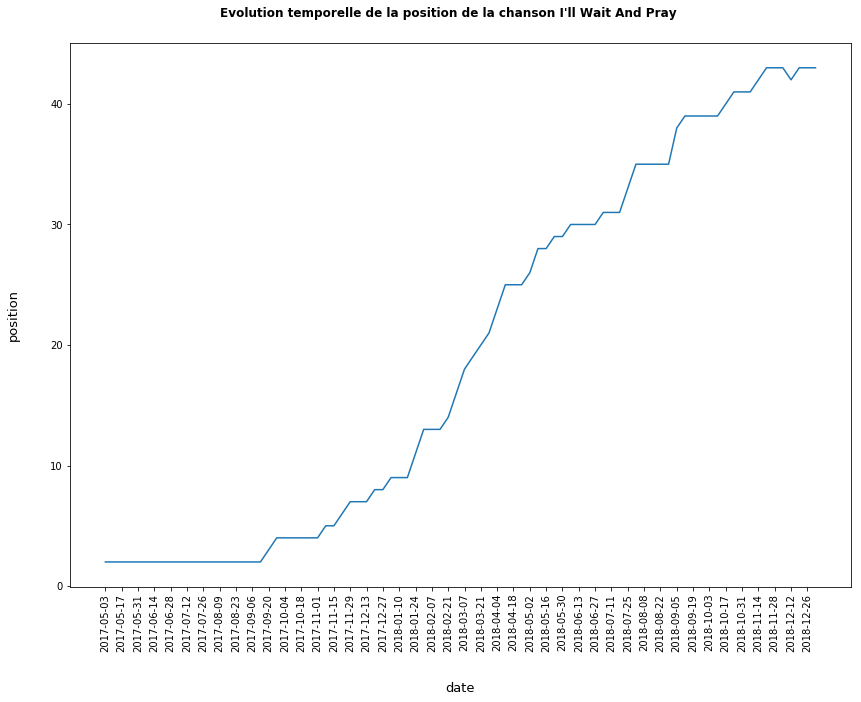

In [52]:
display_time_evolution('jazz', 'I\'ll Wait And Pray')

Entre mai 2017 et décembre 2018, la chanson "I'll wait and pray" a perdu un peu plus de 40 places.

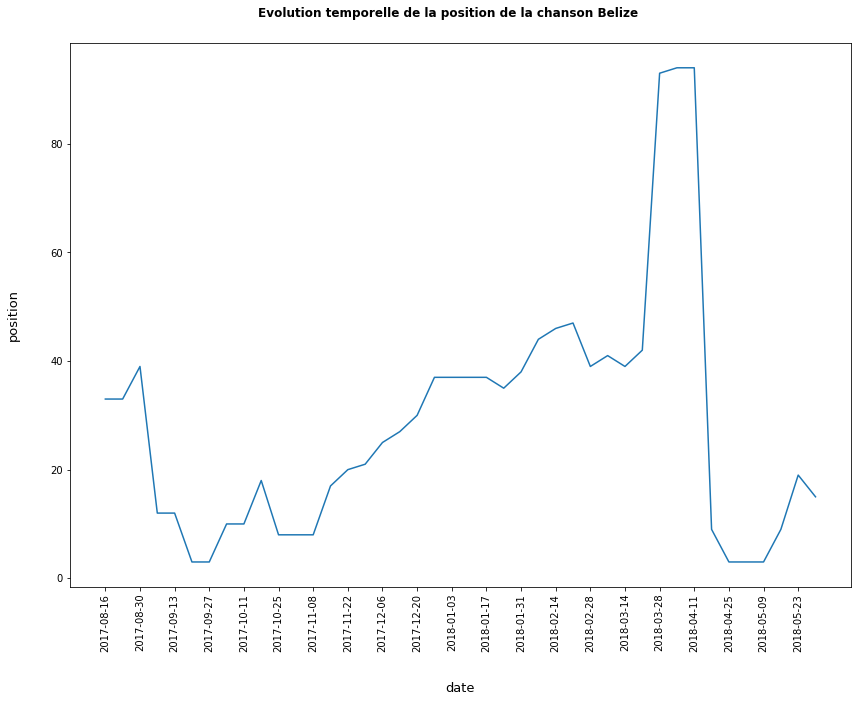

In [53]:
display_time_evolution('electro', 'Belize')

Entre août 2017 et mai 2018, la chanson "Belize" a connu un classement très peu linéaire, marqué par une chute vertigineuse de plus de 50 places en l'espace de quelques semaines (début avril 2018), avant de figurer à nouveau dans le top 20.

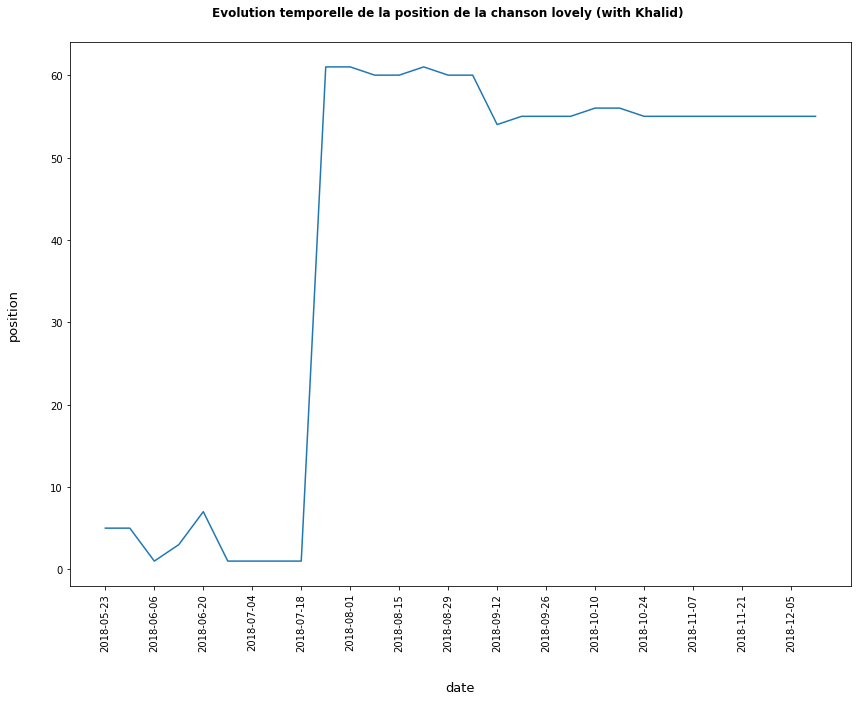

In [54]:
display_time_evolution('lovepop', 'lovely (with Khalid)')

Même remarque ici, où la chanson "lovely (with Kalid)" a perdu près de 60 places en seulement une semaine, avant de se stabiliser autour de la position #55.

### 2.4 Analyse exploratoire multidimensionnelle

_Pour la totalité des playlists, appliquez une méthode de réduction de dimension (ACP, t-
SNE, MDS...) sur les chansons décrites par leurs 10 variables, puis projetez les chansons dans
un plan. Interprétez. Isolez quelques chansons atypiques (outliers) pour chaque playlist._

#### 2.4.1 ACP : Analyse en Composantes Principales

In [55]:
from sklearn.decomposition import PCA

##### Transformation des variables catégoriques en variable numériques (binarisation et encoding)

La variable <i>Mode</i> ne prenant que deux valeurs possibles, celle-ci peut être binarisée. En revanche, pour la variable <i>Key</i>, il faut procéder autrement. Démultiplier la variable en sous-variables par valeur prise possible (dummies) semble déraisonnable, car cela risquerait de lui donner plus de poids dans la suite de notre analyse. Encoder ces valeurs par des entiers, ici allant de 0 à 11, semble être davantage une meilleure option. En effet, même si le sens porté par ces nouvelles valeurs n'a rien d'explicite, cet encodage semble "juste" puisqu'il existe déjà un ordre parmi les valeurs de clefs A, B, C, D, E et F, exprimé en fréquence.

In [56]:
import copy

playlists_encoding = copy.deepcopy(playlists)
key_mapping = {'A':1, 'A#':2, 'B':3, 'C':4, 'C#':5, 'D':6, 'D#':7, 'E':8, 'F':9, 'F#':10, 'G':11, 'G#':12}

def map_key(df):
    return df.map(key_mapping)

def map_mode(df):
    return df.map({'Major':1, 'Minor':0})

In [57]:
for p in playlist_names:
    playlists_encoding[p]['Mode'] = map_mode(playlists_encoding[p]['Mode'])
    playlists_encoding[p]['Key'] =  map_key(playlists_encoding[p]['Key'])

In [58]:
total['Mode'] = map_mode(total['Mode'])
total['Key'] = map_key(total['Key'])

<u>Résultats d'encoding sur la playlist jazz (5 premières chansons) :</u>

In [59]:
playlists_encoding['jazz'].iloc[:,-10:].head(5)

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
0,113,2,0,43,17,12,90,57,30,4
1,95,4,1,42,7,9,87,43,12,4
2,148,6,0,39,7,5,93,85,10,4
3,106,12,1,58,7,8,97,54,11,5
4,65,7,1,44,21,12,92,61,21,4


##### Valeurs propres, vecteurs propres et sélection des axes et plans retenus

In [60]:
from matplotlib.ticker import MaxNLocator

In [61]:
def dimensionality_reduction(playlist):
    
    # Etude des valeurs propres et vecteurs propres : choix du nombre de dimensions (ici limité à deux)
    pca = PCA()
    playlist_bin = pd.get_dummies(playlists_encoding[playlist].iloc[:,-10:])
    coord = pca.fit_transform(playlist_bin)

    eigen_values = pca.explained_variance_
    variance = pca.explained_variance_ratio_
    var_cum = np.cumsum(np.round(variance, decimals=3)*100)
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_ylabel('Variance expliquée')
    ax.set_xlabel('Nombre de composantes principales')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    fig.suptitle('Part de variance expliquée par nombre de composantes principales (playlist {0})'.format(playlist), y=0.94, fontweight='bold')
    plt.plot(var_cum);
    
    # Interprétation des axes (carte de chaleur)
    
    plt.matshow(pca.components_[:2], cmap='coolwarm')
    plt.yticks([0,1], ['1ère CP', '2ème CP', '3ème CP', '4ème CP', '5ème CP', '6ème CP'], fontsize=10)
    plt.colorbar()
    plt.xticks(range(len(playlists_encoding[playlist].iloc[:,-10:].columns)), playlists_encoding[playlist].iloc[:,-10:].columns, rotation=65, ha='left')
    plt.title('Composantes principales et variables associées (playlist {0})'.format(playlist), y=1.7, fontweight='bold')
    plt.show;
    
    # Tracé du cercle de corrélations
    
    (fig, ax) = plt.subplots(figsize=(12, 12))
    for i in range(0, len(pca.components_[:10])):
        ax.arrow(0,
                 0,  # Start the arrow at the origin
                 pca.components_[0, i],  #0 for PC1
                 pca.components_[1, i],  #1 for PC2
                 head_width=0.1,
                 head_length=0.1)

        plt.text(pca.components_[0, i] + 0.1,
                 pca.components_[1, i] + 0.05,
                 playlists_encoding[playlist].iloc[:,-10:].columns.values[i])

    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
    plt.axis('equal')
    ax.set_title('Cercle des corrélations (playlist {0})'.format(playlist), fontweight='bold')
    plt.show()
    
    # Projection des individus dans le plan principal
    
    plt.figure(figsize=(22,16))
    plt.scatter(coord[:, 0], coord[:, 1])
    plt.xlabel('Première composante principale', fontsize=14)
    plt.ylabel('Deuxième composante principale', fontsize=14)
    plt.title('Projection des individus dans le plan principal (playlist {0})'.format(playlist), fontsize=15, fontweight='bold')

    for index, track in playlists[playlist].iterrows():
        try:
            track = ' '.join(track['title'].split()[:3])
            plt.annotate(track, xy=(coord[index, 0], coord[index, 1]), xytext=(coord[index, 0],coord[index, 1]))
        except IndexError as error:
            continue
    plt.show();    

<i> NB : le code relatif au tracé du cercle de corrélation a été repris à partir du post StackOverFlow suivant : https://stackoverflow.com/questions/37815987/plot-a-correlation-circle-in-python

#### 2.4.2 ACP sur la totalité des playlists

<u>__Analyse exploratoire multidimensionnelle sur la playlist 'fr'__</u>

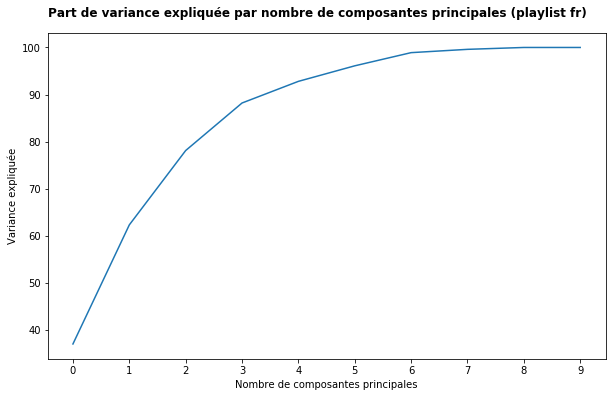

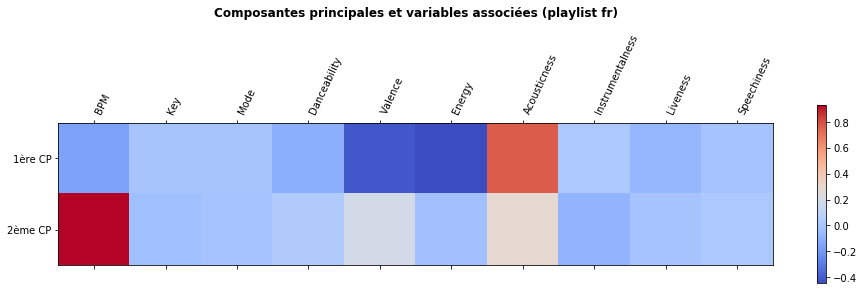

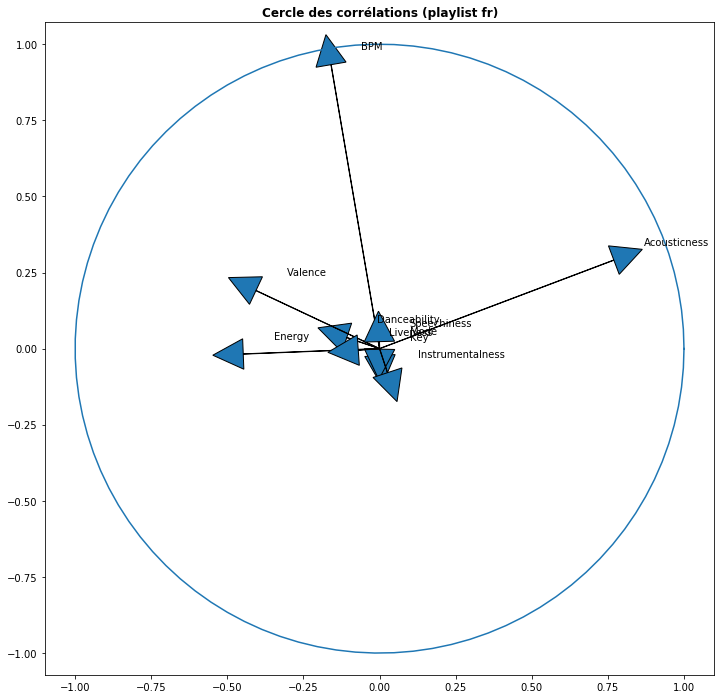

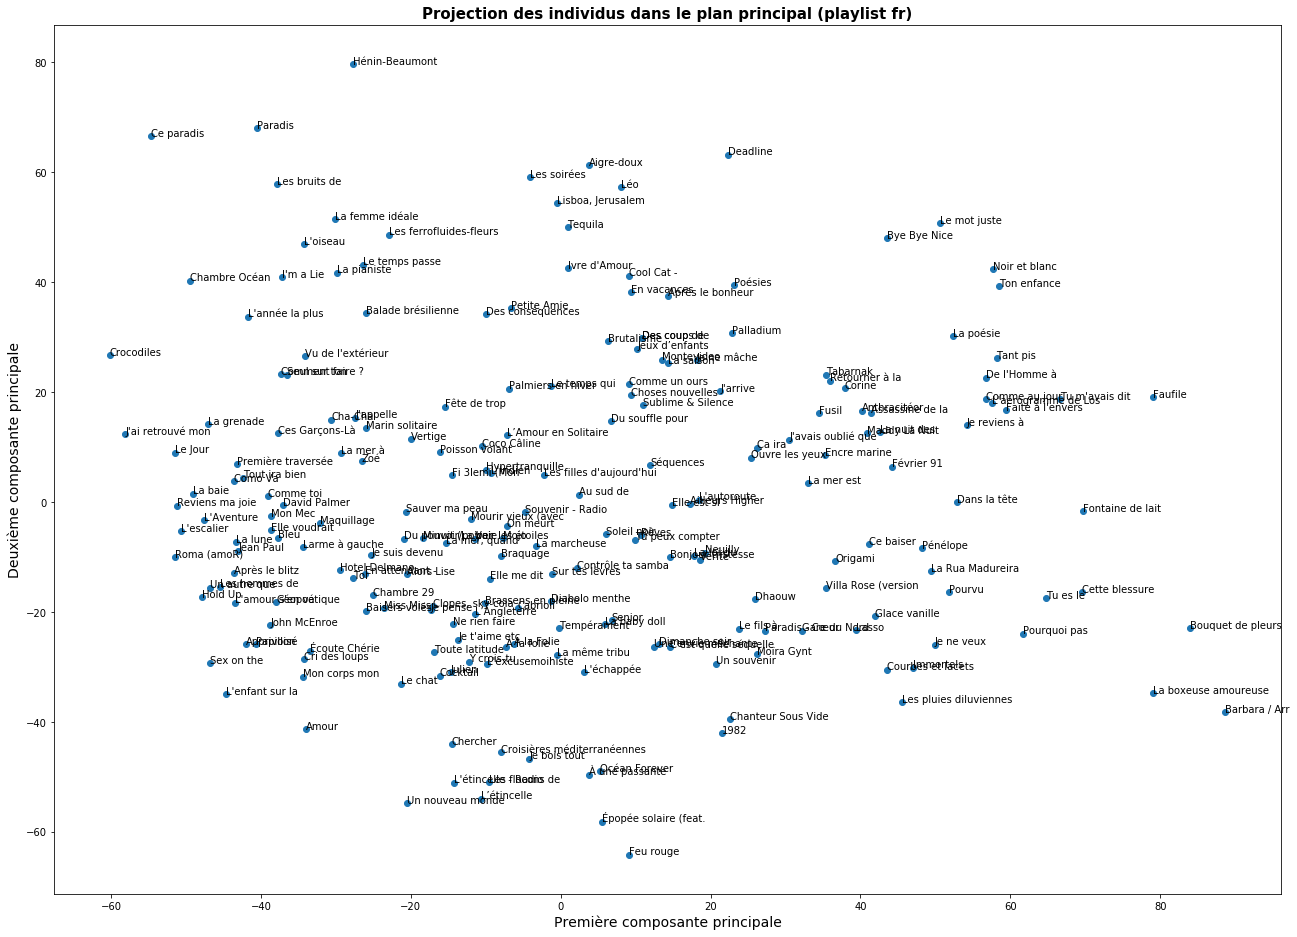

In [62]:
dimensionality_reduction('fr')

Graphique 1 : On remarque qu'avec 6 composantes principales, la totalité de la variance est expliquée. Les deux premières composantes expliquent près de 80% de la variance totale, ce qui est plutôt bon. Le plan principal est donc suffisamment représentatif.

Graphique 2 : La première composante principale est corrélée positivement à l'<i>Acousticness</i> et négativement à la <i>Valence</i> et l'<i>Energy</i>. La deuxième composante est quant à elle fortement liée à la variable <i>BPM</i>.

Graphique 3 : On retrouve sur le tracé du cercle des corrélations les analyses faites à partir du Graphique 2. Le premier axe est bien défini par les variables <i>Acousticness</i> d'une part (positivement) et <i>Valence</i> et <i>Energy</i> d'autre part (négativement), bien que ces deux dernières soient assez mal représentées dans ce plan (éloignées du bord du cercle de corrélation). Le second axe est lié à la variable <i>BPM</i>.

Graphique 4 : La projection des individus dans le plan principal est relativement diffus/éparse, mais laisse apparaître quelques outliers, tels que "Hénin-Beaumont". Si l'on se réfère au cercle des corrélations, on peut en déduire qu'il s'agit d'une musique au tempo très rapide (variable BPM). La chanson "Bouquet de pleurs", quant à elle, est marquée par une grande accoustique.<br>
<br>Les résumés des caractéristiques de ces deux chansons, publiés ci-dessous, permettent de corroborer ces interprétations.

<u>Résumé numérique et catégorique moyen d'une chanson française :</u>

In [63]:
global_summary('fr')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
top,NaN,C,Minor,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,117.561644,NaN,NaN,62.155251,48.652968,56.182648,38.748858,9.575342,15.424658,5.789954


<u>Résumé numérique et catégorique de la chanson "Hénin-Beaumont"</u>

In [64]:
title_summary('fr', 'Hénin-Beaumont')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
20,198,F#,Minor,40,72,78,41,0,8,7


<u>Résumé numérique et catégorique de la chanson "Bouquet de pleurs"</u>

In [65]:
title_summary('fr', 'Bouquet de pleurs')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
91,80,B,Minor,34,21,14,97,1,12,4


<u>__Analyse exploratoire multidimensionnelle sur la playlist 'electro'__</u>

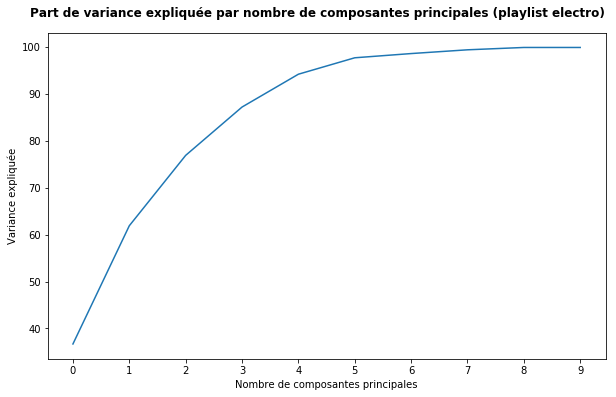

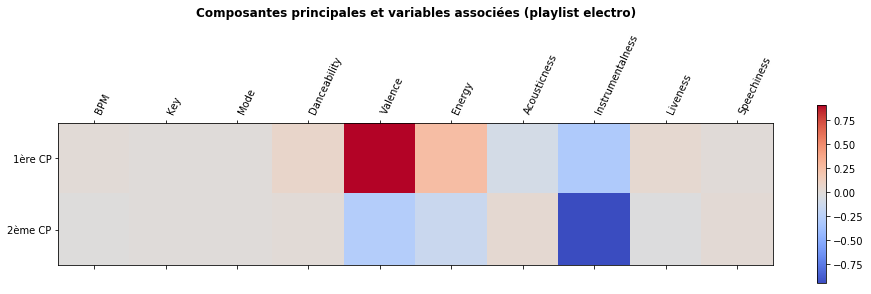

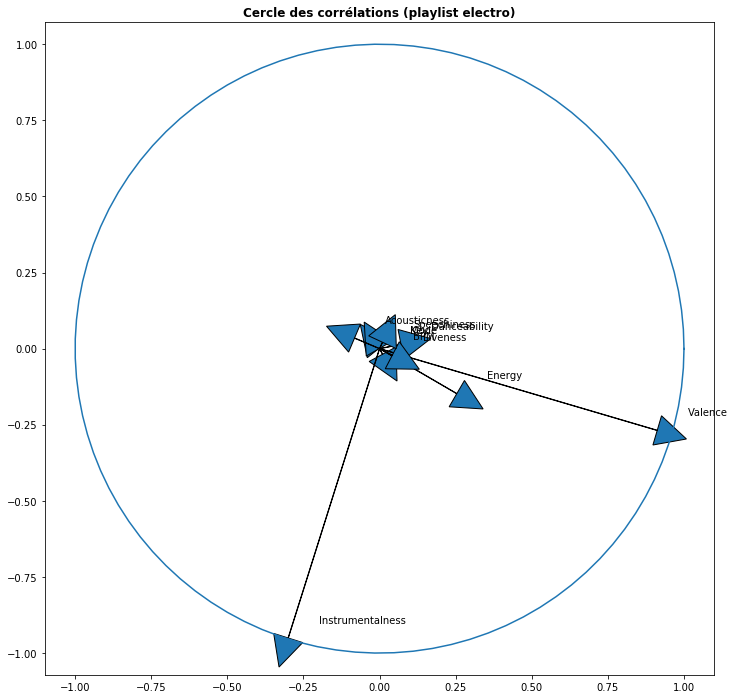

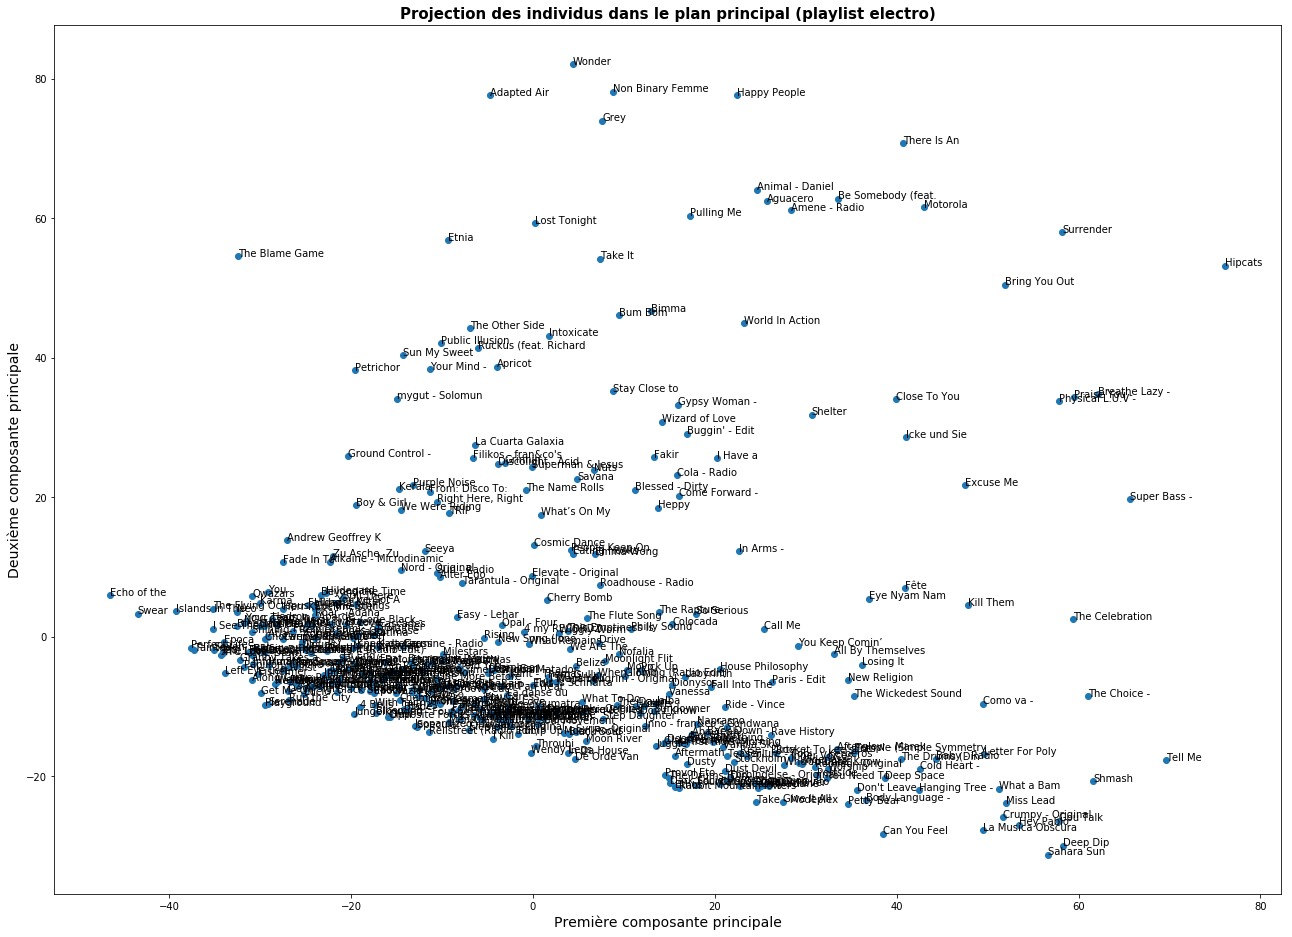

In [66]:
dimensionality_reduction('electro')

Graphique 1 : Le plan principal est là encore suffisamment représentatif, puisqu'un peu moins de 80% de la variance totale est expliquée.

Graphique 2 : La première composante principale est positivement corrélée à la <i>Valence</i> et négativement (dans une moindre mesure) à l'<i>Instrumentalness</i>. La deuxième composante est quant à elle fortement liée à cette dernière variable.

Graphique 3 : On retrouve sur le tracé du cercle des corrélations les analyses faites plus haut. Le premier axe est bien défini par la variable <i>Valence</i> et, le second axe, par la variable <i>Instrumentalness</i>.

Graphique 4 : La projection des individus dans le plan principal est cette fois-ci moins hétérogène, laissant apparaître un dense nuage de points situé en partie inférieure. Il semblerait que les musiques electro soient, de manière générale, marquées par une grande instrumentalité. Les outliers sont cependant nombreux ; "The Blame Game", "Hipcats" ou encore "Super Bass - Wade Remix" ("Super Bass - ...") apparaissent isolés :
* La chanson "The Blame Game" est marquée par des valeurs de <i>Valence</i> très faibles ;
* La chanson "Hipcats", située à l'opposé même, enregistre les caractéristiques contraires (forte valence, mais aussi forte énergie) ;
* La chanson "Super Bass - Wade Remix", apparaît quant à elle très énergique/intense (comme "Hipcats"), mais est davantage instrumentale.

<u>Résumé numérique et catégorique moyen d'une chanson electro :</u>

In [67]:
global_summary('electro')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
top,NaN,G,Major,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,123.206651,NaN,NaN,75.427553,33.866983,72.16152,4.330166,78.118765,14.030879,6.244656


<u>Résumé numérique et catégorique de la chanson "The Blame Game"</u>

In [68]:
title_summary('electro', 'The Blame Game')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
122,102,A,Minor,39,4,41,86,37,11,8


<u>Résumé numérique et catégorique de la chanson "Hipcats"</u>

In [69]:
title_summary('electro', 'Hipcats')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
211,122,C,Major,88,85,98,0,4,2,6


<u>Résumé numérique et catégorique de la chanson "Super Bass - Wade Remix"</u>

In [70]:
title_summary('electro', 'Super Bass - Wade Remix')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
259,124,F#,Major,83,85,97,0,39,15,7


<u>__Analyse exploratoire multidimensionnelle sur la playlist 'jazz'__</u>

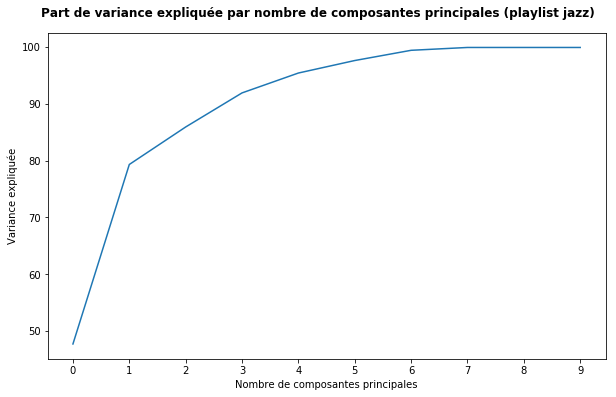

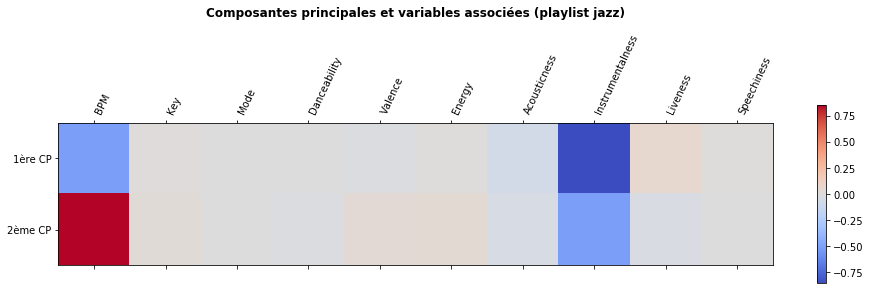

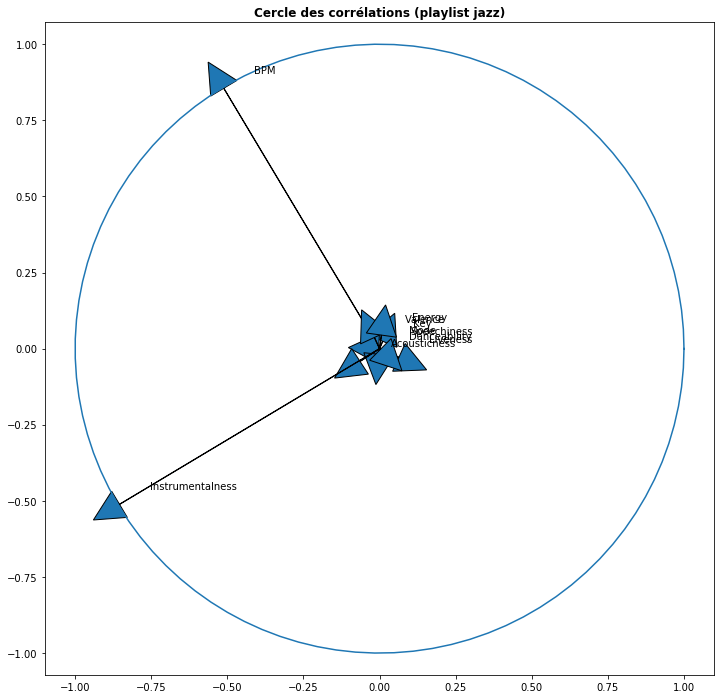

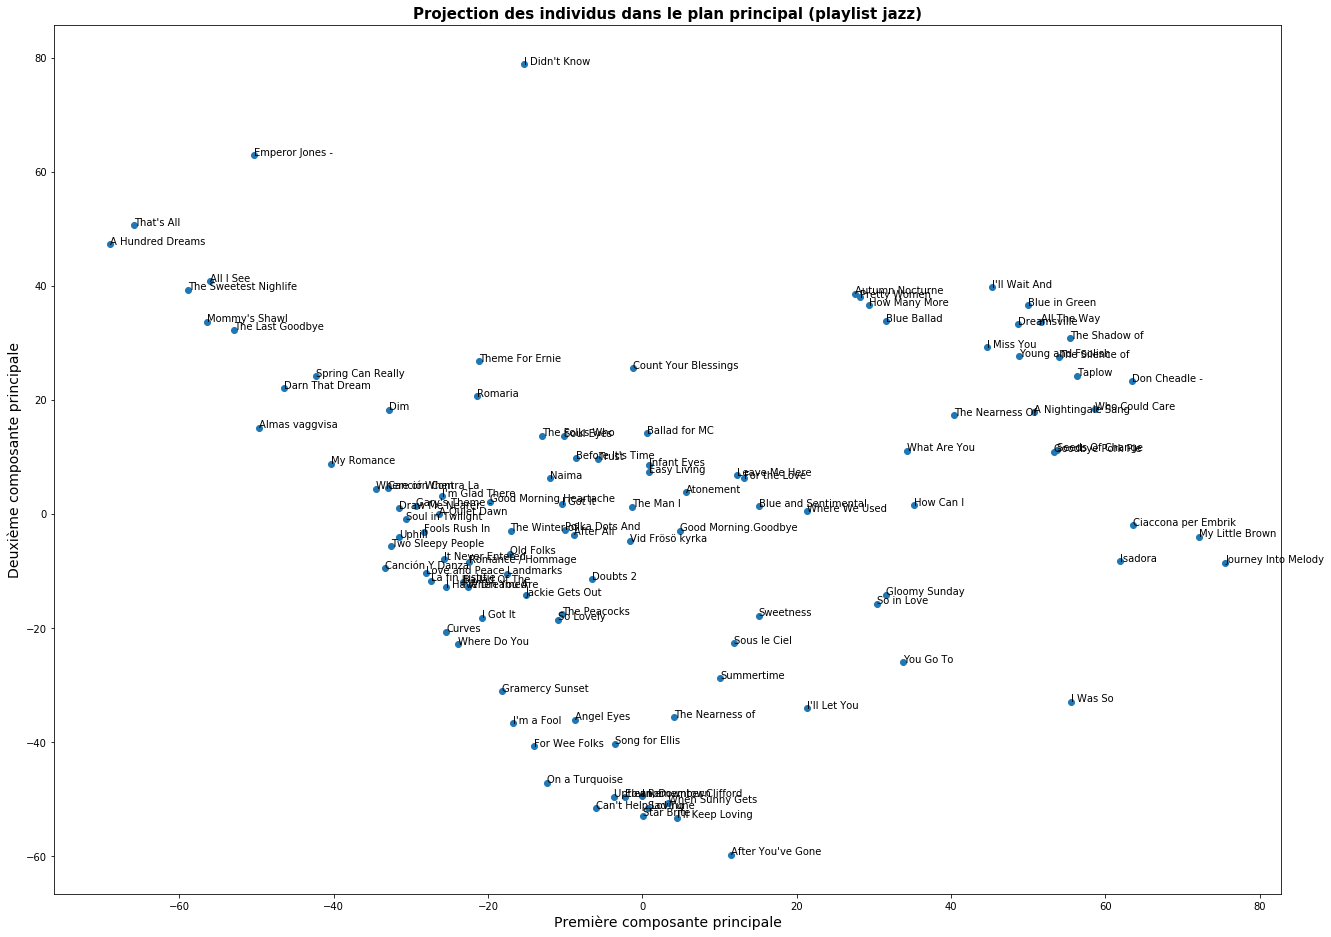

In [71]:
dimensionality_reduction('jazz')

Graphique 1 : Même remarque : 80 % de la variance totale est expliquée par les deux premiers axes, ce qui est satisfaisant.

Graphique 2 : La première composante principale est positivement corrélée à l'<i>Instrumentalness</i> et à la variable <i>BPM</i>. La seconde composante principale est négativement corrélée à la variable <i>BPM</i>, et positivement corrélée à l'<i>Instrumentalness</i>. Ces deux variables sont non corrélées, comme en atteste l'angle droit formé.

Graphique 3 : On retrouve sur le tracé du cercle des corrélations les analyses faites plus haut. Le premier axe est bien défini par la variable <i>Instrumentalness</i> et, le second axe, par la variable <i>BPM</i>.

Graphique 4 : De façon générale, les musiques jazz sont marquées par une grande instrumentalité. La projection des individus dans le plan principal, relativement éparse, laisse apparaître quelques groupes de musiques partageant des caractéristiques communes, tel que celui formé (entre autres) par les chansons "I'll Wait And Pray", "Blue in Green" ou encore "All The Way", semblant aller à l'encontre de la tendance générale. Le cercle des corrélations permet en effet de déduire qu'il s'agit de musiques non instrumentales. Les résumés joints ci-dessous confirment ces observations.<br>

Les chansons "I Didn't Know" et "I Was So Young, and You Were So Beautiful" ("I Was So...") apparaissent ici en tant qu'outliers :
* La chanson "I Didn't Know" est marquée par un très grand tempo (très forte BPM) ;
* La chanson "I Was So Young, and You Were So Beautiful", à l'opposé, est une musique vraisemblablement lente (très faible BPM).


<u>Résumé numérique et catégorique moyen d'une chanson jazz :</u>

In [72]:
global_summary('jazz')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
top,NaN,C,Major,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,105.123894,NaN,NaN,44.0,17.495575,13.707965,90.513274,61.690265,15.318584,3.946903


<u>Résumé numérique et catégorique de la chanson "I'll Wait And Pray"</u>

In [73]:
title_summary('jazz', 'I\'ll Wait And Pray')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
10,116,F,Minor,48,23,6,89,2,13,4


<u>Résumé numérique et catégorique de la chanson "Blue in Green"</u>

In [74]:
title_summary('jazz', 'Blue in Green')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
73,111,D,Minor,42,16,2,81,0,10,4


<u>Résumé numérique et catégorique de la chanson "All The Way"</u>

In [75]:
title_summary('jazz', 'All The Way')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
97,107,C,Minor,42,19,16,72,1,10,3


[Outliers]

<u>Résumé numérique et catégorique de la chanson "I Didn't Know About You"</u>

In [76]:
title_summary('jazz', 'I Didn\'t Know About You')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
105,180,G#,Minor,36,25,16,94,34,9,4


<u>Résumé numérique et catégorique de la chanson "I Was So Young, and You Were So Beautiful"</u>

In [77]:
title_summary('jazz', 'I Was So Young, and You Were So Beautiful')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
66,48,C#,Major,32,16,3,94,30,8,3


<u>__Analyse exploratoire multidimensionnelle sur la playlist 'lovepop'__</u>

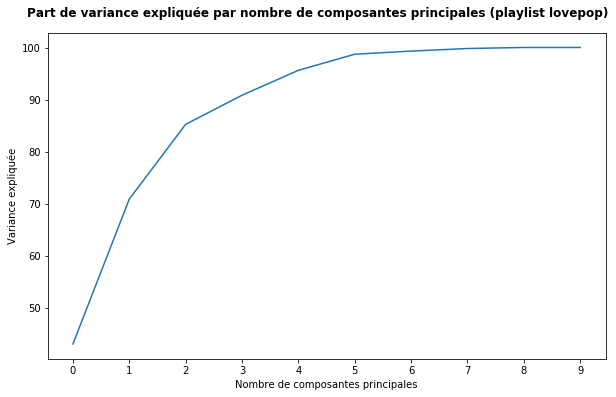

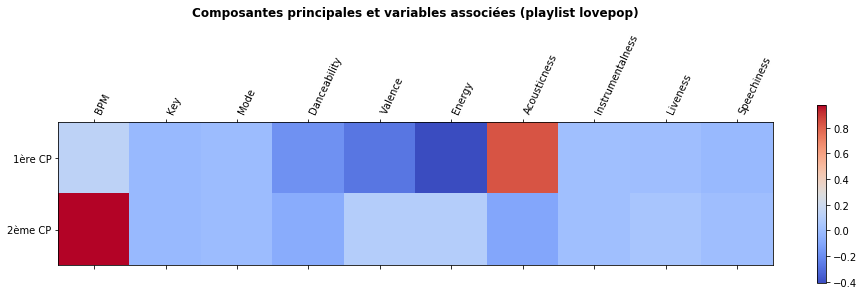

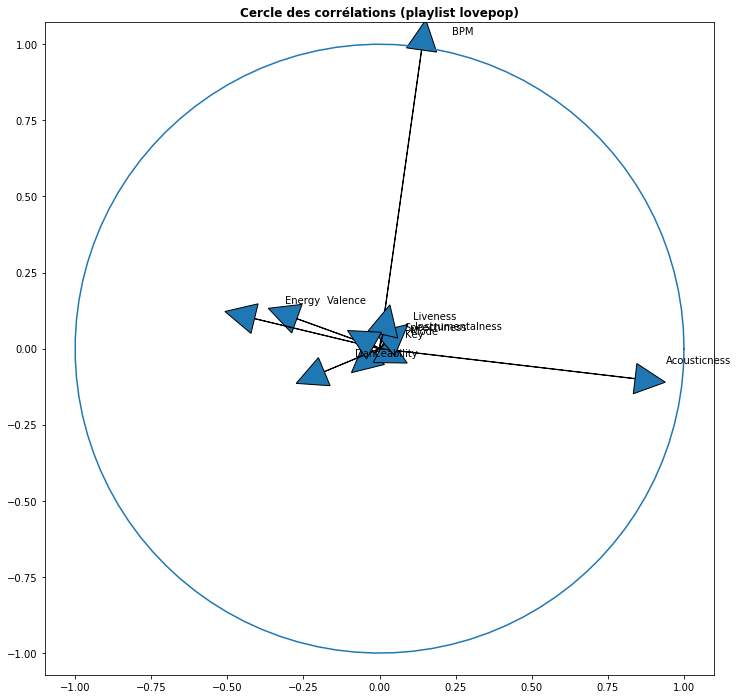

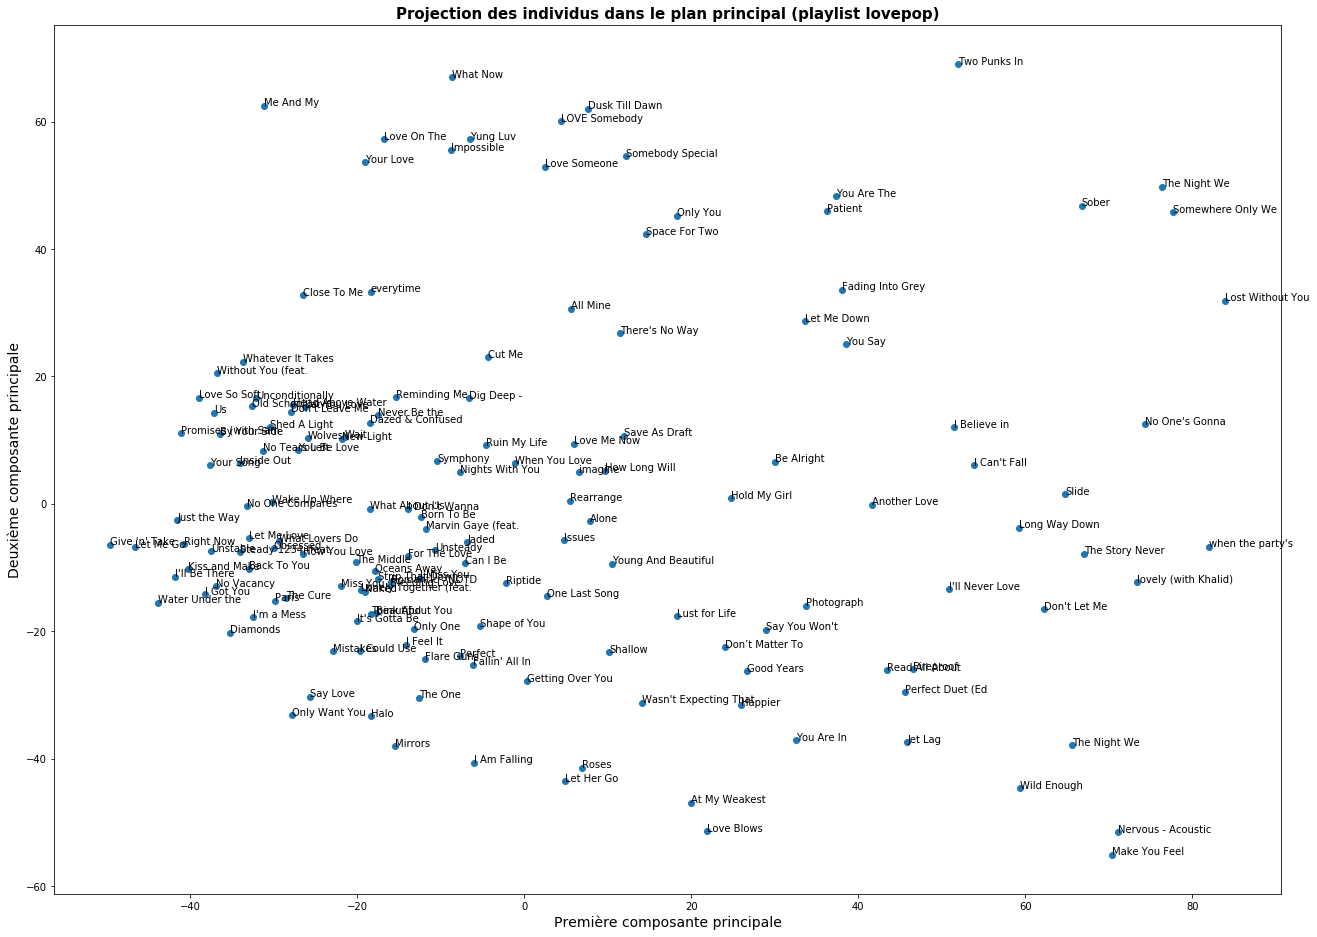

In [78]:
dimensionality_reduction('lovepop')

Graphique 1 : La qualité de la projection dans le plan principal apparaît ici d'autant meilleure que les deux premières composantes suffisent à expliquer 85% de la variance totale.

Graphique 2 : La première composante principale est positivement corrélée à l'<i>Acousticness</i> et négativement aux variables <i>Energy</i>, <i>Valence</i> et <i>Danceability</i>. La seconde composante principale est positivement et très fortement corrélée à la variable <i>BPM</i>.

Graphique 3 : On retrouve sur le tracé du cercle des corrélations les analyses faites à partir du Graphique 2.

Graphique 4 : La projection des individus dans le plan principal est relativement éparse. Un nuage plus dense d'individus, situé en partie basse de la projection, laisse penser que les chansons pop sont marquées par une faible valeur de <i>BPM</i> (tempo lent). <br>On repère quelques outliers, parmi lesquels "Two Punks In Love" ("Two Punks In..."), "Me And My Broken Heart" ("Me And My...") et "Lost Without You" :
* La chanson "Two Punks In Love" est marquée par un très grand tempo (très forte BPM) ;
* La chanson "Me And My Broken Heart" (angle gauche, partie haute), est une musique de très faible accoustique ;
* La chanson "Lost Without You" est, à l'inverse de la chanson précédente, une musique de très grande accoustique.

Les autres variables étant mal représentées dans ce plan, on ne pas pas faire davantage d'hypothèses sur ces chansons.

<u>Résumé numérique et catégorique moyen d'une chanson lovepop :</u>

In [79]:
global_summary('lovepop')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
top,NaN,G#,Major,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,117.535484,NaN,NaN,60.348387,39.316129,56.335484,34.193548,0.516129,14.490323,5.748387


<u>Résumé numérique et catégorique de la chanson "Two Punks In Love"</u>

In [80]:
title_summary('lovepop', 'Two Punks In Love')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
79,190,C,Major,50,80,42,88,0,11,5


<u>Résumé numérique et catégorique de la chanson "Me And My Broken Heart"</u>

In [81]:
title_summary('lovepop', 'Me And My Broken Heart')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
64,174,F,Minor,55,51,78,1,0,19,3


<u>Résumé numérique et catégorique de la chanson "Lost Without You"</u>

In [82]:
title_summary('lovepop', 'Lost Without You')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
77,162,F#,Major,41,11,14,93,0,7,4


<u>__Analyse exploratoire multidimensionnelle sur la playlist 'metal'__</u>

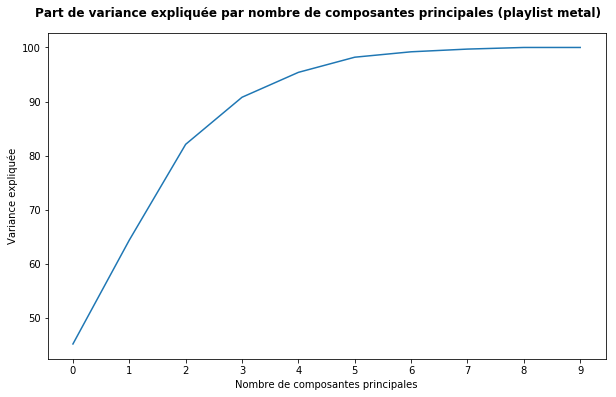

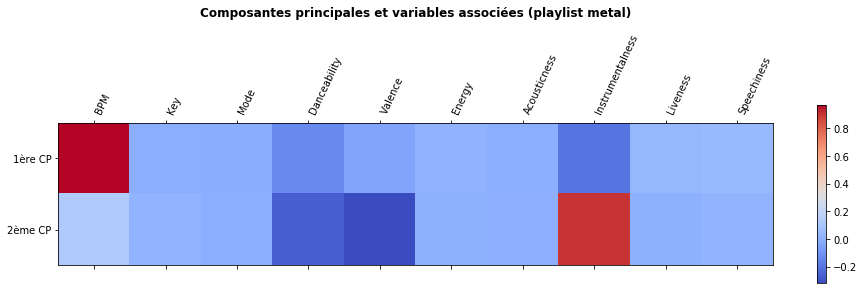

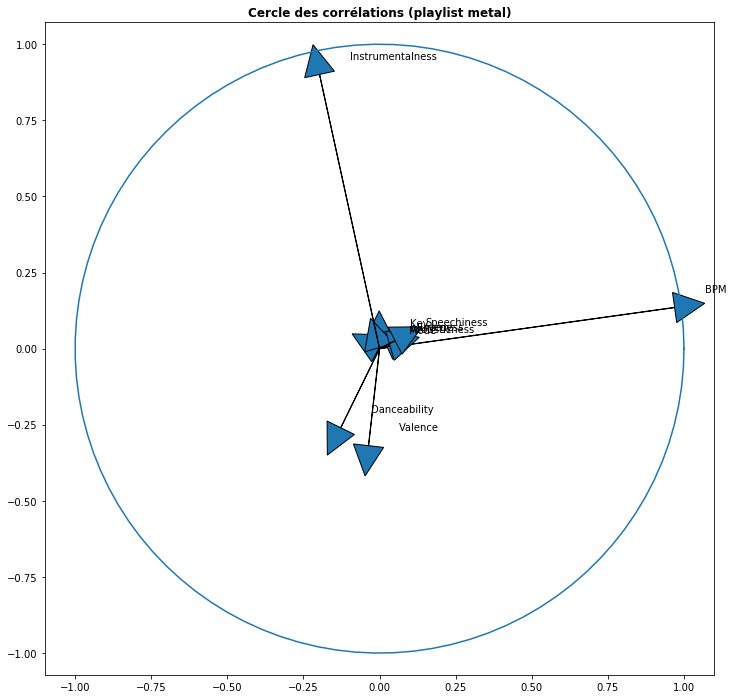

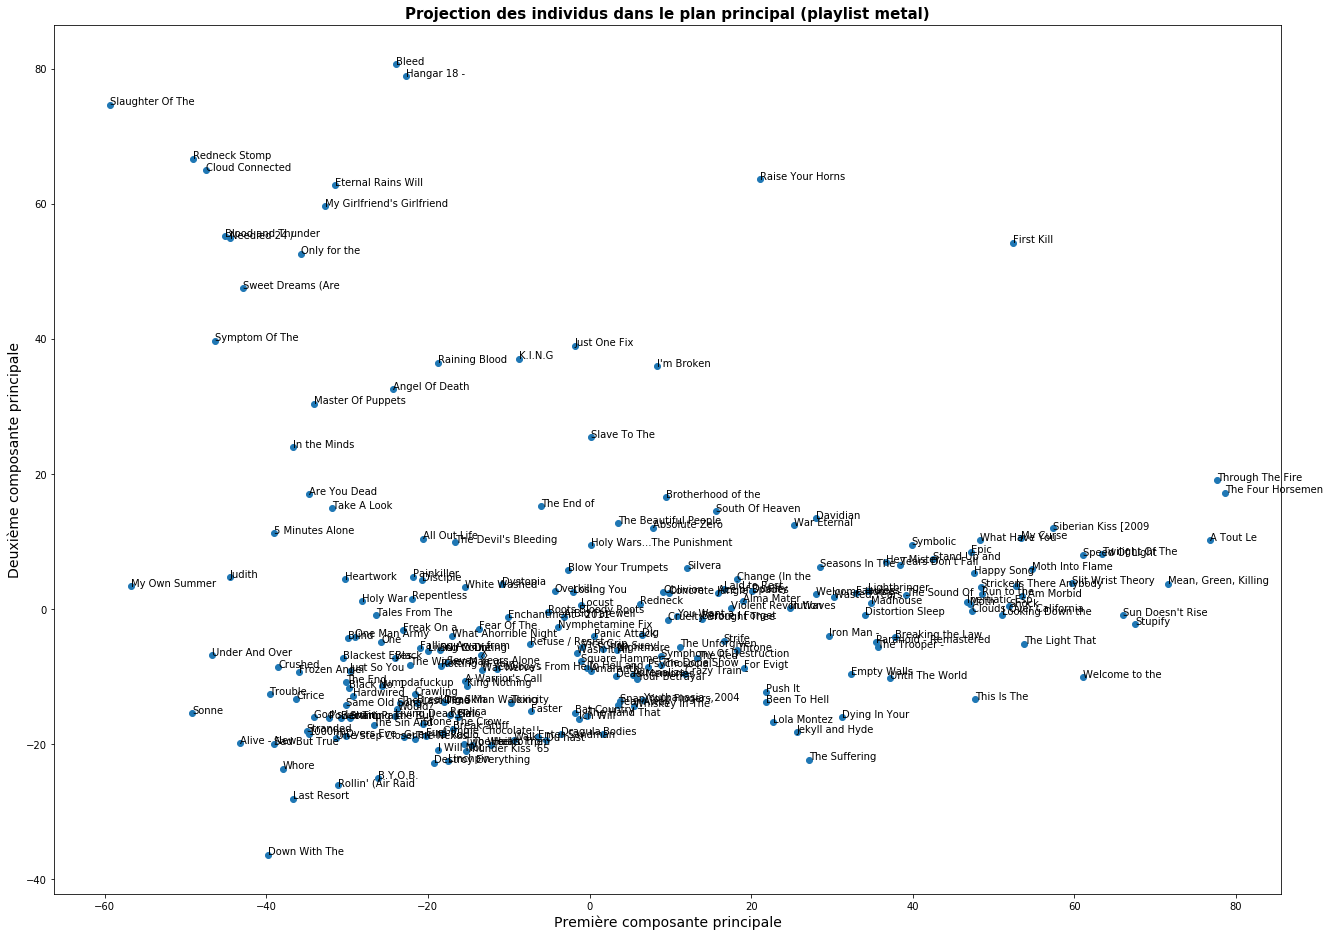

In [83]:
dimensionality_reduction('metal')

Graphique 1 : Là encore, le plan principal assure une bonne qualité de projection, un peu plus de 80% de la variance totale étant expliquée.

Graphique 2 : La première composante principale est positivement et très fortement corrélée à la <i>BPM</i> et négativement à l'<i>Instrumentalness</i>.<br> La seconde composante principale est positivement corrélée à la variable <i>Instrumentalness</i> et négativement corrélée à la <i>Valence</i>, ainsi qu'à la <i>Danceability</i>.

Graphique 3 : On retrouve sur le tracé du cercle des corrélations les analyses faites à partir du Graphique 2. On veillera toutefois à ne pas tirer de conclusions trop hâtives vis-à-vis des variables <i>Valence</i> et <i>Danceability</i>, ici beaucoup moins bien représentées (projections éloignées du bord du cercle).

Graphique 4 : La projection des individus dans le plan principal est concentrée dans la partie basse, laissant penser que la plupart des chansons metal ont une faible instrumentalité. On repère quelques groupes de musiques tel que celui formé par les chansons "Through The Fire" et "The Four Horsemen - Remastered" ("The Four Horsemen..."), à l'extrême-droite de la projection, caractérisées par une valeur de BPM très supérieure à la moyenne. Celui composé des musiques "Bleed" et "Hangar 18 - 2004 Digital Remaster" ("Hangar 18 -..."), regroupe, contrairement à la tendance générale, des chansons très instrumentales. <br>Parmi les outliers, on peut citer les chansons "First Kill", "Raise Your Horns" ou encore "Down With The Sickness" ("Down With The...") :

* La chanson "First Kill" apparaît comme relativement instrumentale et, hypothétiquement de faible <i>Valence</i> et <i>Danceability</i>;
* La chanson "Raise Your Horns" enregistre des caractéristiques semblables, même si sa valeur de BPM apparaît comme inférieure.
* La chanson "Down With The Sickness" enregistre un tempo très lent (BPM). Ses valeurs de <i>Valence</i> et <i>Danceability</i> semblent plus hautes que la moyenne.

<u>Résumé numérique et catégorique moyen d'une chanson metal :</u>

In [84]:
global_summary('metal')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
top,NaN,D,Major,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,127.414414,NaN,NaN,43.220721,38.04955,91.963964,0.459459,9.04955,19.644144,9.297297


<u>Résumé numérique et catégorique de la chanson "First Kill"</u>

In [85]:
title_summary('metal', 'First Kill')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
117,189,G,Major,32,24,93,0,52,4,5


<u>Résumé numérique et catégorique de la chanson "Raise Your Horns"</u>

In [86]:
title_summary('metal', 'Raise Your Horns')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
19,165,F,Major,46,52,88,0,80,15,5


<u>Résumé numérique et catégorique de la chanson "Down With The Sickness"</u>

In [87]:
title_summary('metal', 'Down With The Sickness')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
11,90,A#,Minor,65,92,90,0,0,10,6


## 3. Analyse prédictive

Les doublons ayant été déjà écartés, aucun autre échantillon ne sera supprimé. Ainsi, les outliers repérés seront conservés, de façon à ne pas trop amputer la taille du jeu de données. <br>Aucun prétraitement, mis à part ceux liés à la transformation de variables (centrage-réduction) n'a donc ici été appliqué.

In [88]:
from graphviz import Source
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer, r2_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn import tree

### 3.1 Modèle prédictif d'une playlist

_En considérant toutes les playlists, ou bien en opposant deux playlists seulement, construisez
un modèle permettant d'expliquer (=reconnaître) la playlist en fonction des 10 variables.
Évaluez le modèle et interprétez._

#### 3.1.1 Modèle "boîte blanche"

Les variables explicatives sont les 8 variables numériques et les 2 variables catégoriques.

In [89]:
variables = ['BPM', 'Key', 'Mode', 'Danceability', 'Valence','Energy',
             'Acousticness','Instrumentalness', 'Liveness', 'Speechiness']

Le modèle sera ici construit en considérant toutes les playlists.

In [90]:
features = total[variables]
data_dimension(features)

1130 enregistrements décrits par 10 champs : BPM, Key, Mode, Danceability, Valence, Energy, Acousticness, Instrumentalness, Liveness, Speechiness


La variable cible à prédire est le type de la playlist (attribut <i>playlist</i>).<br>

In [91]:
target_names = total['playlist']

#### <u>Arbres de classification<u>

##### Apprentissage et validation

In [92]:
X_train, X_test, y_train, y_test = train_test_split(features, target_names, test_size=0.2, random_state=1)

In [93]:
dtc = tree.DecisionTreeClassifier(random_state=1)

depths = np.arange(1, 21)
num_leafs = [1, 5, 10, 20, 50, 100]
dtc_grid_parameters = {'criterion':['gini','entropy'], 'max_depth':depths, 
                        'min_samples_leaf':num_leafs}


dtc_gs = GridSearchCV(dtc, dtc_grid_parameters, cv=10, iid=True)
dtc_gs.fit(X_train, y_train);

In [94]:
dtc_gs.best_params_

{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 10}

Le meilleur paramétrage, indiqué ci-dessus, sera donc appliqué. Il semble bon, dans la mesure où les risques d'overfitting apparaissent ici comme limités (profondeur moyenne, plusieurs échantillons par noeud terminal).

In [95]:
dtc = dtc_gs.best_estimator_
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

##### Test

<u>Validation simple</u>

In [96]:
y_pred = dtc.predict(X_test)
accuracy_score(y_test, y_pred)

0.8097345132743363

<u>Validation croisée</u>

In [97]:
cross_val_score(dtc, features, target_names, cv=10).mean()

0.8070551458791071

En validation simple comme croisée, le score d'accuracy obtenu en phase de test est d'environ 0.81, ce qui est plutôt satisfaisant.

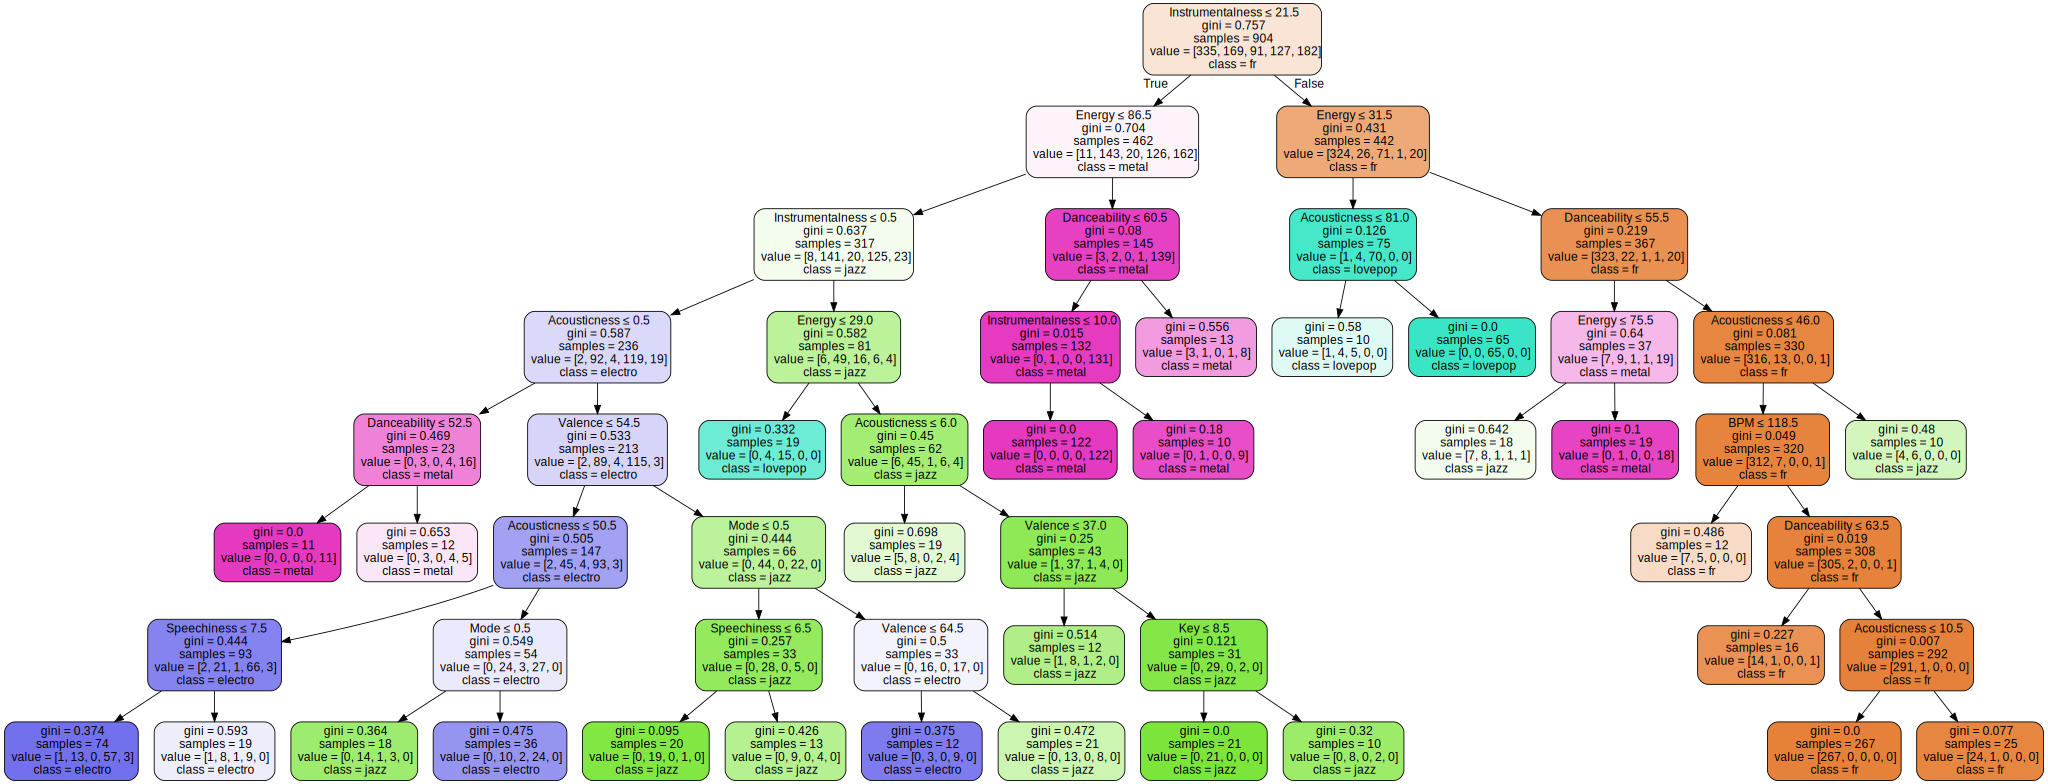

In [98]:
Source(tree.export_graphviz(dtc, filled=True, rounded=True, special_characters=True, feature_names=features.columns.values, class_names=target_names.unique()))

Le premier critère de partitionnement porte sur la variable <i>Instrumentalness</i>, séparant les données en deux ensembles de tailles égales (+/- 20). <br>Si l'on se réfère aux noeuds terminaux, ce premier point de coupure laisse apparaître que les musiques electro ont un taux d'instrumentalité bas (partie gauche de l'arbre), tandis que les chansons françaises, toutes regroupées du côté droit de l'arbre, apparaissent comme davantage parlées.
Parmi les variables de décision clefs figurent également l'<i>Energy</i>, la <i>Danceability</i> et l'<i>Acousticness</i>.

Les chansons françaises d'abord et metal ensuite sont celles ayant été le mieux identifiées. En effet, on remarque que 267 chansons françaises ont été regroupées ensemble d'une part, et 122 musiques metal d'autre part, avec un indice de gini toujours égal à 0 (noeuds purs). Il apparaît que les chansons françaises, situées à l'extrême-droite de l'arbre, sont des chansons plutôt instrumentales, de faible accoustique (seuil à 46%), relativement rythmées et dansantes. De meilleurs résultats auraient pu être espérés si les 2 outliers jazz avaient été retirés au préalable. Même constat du côté des chansons metal, où 2 outliers jazz de très forte BPM séparent les 131 musiques metal en deux groupes distincts de 122 et 9 échantillons. On peut toutefois sans risque conclure qu'il s'agit de musiques davantage parlées qu'instrumentales, mais aussi très énergiques/toniques.

Les musiques lovepop ont elles aussi été plutôt bien classées, 65 d'entres elles ayant été regroupées ensemble au sein d'un noeud pur. De façon générale, il s'agit de musiques chantées (faible instrumentalité), peu toniques.

Les critères de regroupement des musiques jazz semblent de leur côté moins linéaires. En effet, les musiques jazz sont disséminées en plusieurs petits groupes, mais à la quasi-unanimité dans la partie gauche de l'arbre, de la même façon que le sont les musiques electro (haute instrumentalité). Ce sont les critères de partitionnement liés à l'<i>Acousticness</i> et à la <i>Valence</i> qui semblent permettre de faire la distinction entre ces deux genres musicaux, les musiques jazz ayant une plus grande valence.

#### 3.1.1 Modèle "boîte noire"

On pourrait désormais s'intéresser aux performances (précision/rappel) enregistrées par un modèle de type "boîte noire".

#### <u>Méthode des K plus proches voisins<u>

Les 10 variables seront centrées et réduites en amont. L'utilisation d'une méthode d'apprentissage reposant sur des calculs de distance préconise cette étape de transformation, et ce afin de lisser les différentes échelles de valeurs et attribuer le même poids à toutes les variables.

In [99]:
scaler = StandardScaler()

def scale_dataframe(df):
    scaled = scaler.fit_transform(df.astype(float).values)
    df =  pd.DataFrame(scaled, columns=variables)
    return df

features_scaled = scale_dataframe(features)

##### Apprentissage et validation

In [100]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_names, test_size=0.2, random_state=1)

In [101]:
knn = KNeighborsClassifier()

knn_grid_parameters = {'n_neighbors': np.arange(1, 50)}
knn_gs = GridSearchCV(knn, knn_grid_parameters, cv=5)
knn_gs.fit(features_scaled, target_names)

print(knn_gs.best_params_)
print(knn_gs.best_score_)

{'n_neighbors': 47}
0.815929203539823


Le paramètre K (n_neighbors) sera donc ici fixé à 47.

In [102]:
knn = knn_gs.best_estimator_
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=47, p=2,
           weights='uniform')

##### Test

<u>Validation simple</u>

In [103]:
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.8185840707964602

<u>Validation croisée</u>

In [104]:
cross_val_score(knn, features_scaled, target_names, cv=10).mean()

0.8105946588285452

Le score d'accuracy obtenu en phase de test est de 0.82, donc très semblable à celui obtenu à partir de l'algorithme d'apprentissage basé sur un arbre de décision. Ce modèle boîte noire ne permet donc pas d'espérer de meilleurs résultats. Il peut toutefois être intéressant d'étudier plus précisément la nature de ces résultats, en confrontant les données réelles et celles de test, de façon à repérer les échantillons mal classés.

In [105]:
test_pred = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred})
test_pred['prediction'] = np.where(test_pred['y_pred']==test_pred['y_test'], True, False)
test_pred = test_pred[['y_test', 'y_pred', 'prediction']]
res = test_pred.loc[test_pred['prediction'] == False].sort_values(['y_pred'])

In [106]:
res.groupby(y_test).size()

playlist
electro     2
fr         19
lovepop    18
metal       2
dtype: int64

Les musiques electro et metal sont celles ayant été le mieux reconnues : seules 2 d'entre elles ont été respectivement mal classées.<br> À l'inverse, les musiques françaises lovepop sont celles ayant posé le plus de difficultés au modèle, avec 19 et 18 erreurs. 

In [107]:
res.loc[res['y_test']=='fr'].head(10)

,y_test,y_pred,prediction
186,fr,electro,False
195,fr,electro,False
204,fr,electro,False
202,fr,jazz,False
35,fr,jazz,False
139,fr,lovepop,False
180,fr,lovepop,False
120,fr,lovepop,False
85,fr,lovepop,False
78,fr,lovepop,False


Comme on peut ici le voir, il semblerait que la plupart des chansons françaises aient été prédites comme des chansons lovepop. Ces résultats ne sont pas si abberrants si l'on se reporte aux analyses faites plus haut, car les musiques appartenant à ces deux genres présentent de nombreuses caractéristiques communes, avec des valeurs de <i>BPM</i>, <i>Danceability</i>, d'<i>Energy</i>, de <i>Liveness</i>, de <i>Speechiness</i> et d'<i>Acousticness</i> quasi identiques. Seules les variables <i>Instrumentalness</i> et <i>Mode</i> semblent pouvoir différencier les musiques françaises des musiques lovepop (cf. résumés joints ci-contre).

In [108]:
global_summary('fr')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
top,NaN,C,Minor,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,117.561644,NaN,NaN,62.155251,48.652968,56.182648,38.748858,9.575342,15.424658,5.789954


In [109]:
global_summary('lovepop')

,BPM,Key,Mode,Danceability,Valence,Energy,Acousticness,Instrumentalness,Liveness,Speechiness
top,NaN,G#,Major,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,117.535484,NaN,NaN,60.348387,39.316129,56.335484,34.193548,0.516129,14.490323,5.748387


### 3.2 Modèle prédictif de position pic

_Pour la playlist de votre choix ou bien la totalité des playlists, construisez un modèle
permettant d'expliquer la position d'une chanson. Évaluez le modèle et interprétez._

In [110]:
total.columns

Index(['position', 'title', 'artists', 'url', 'date', 'playlist',
       'broadcasting_time', 'pic_position', 'av_position', 'pic_bool',
       'av_bool', 'BPM', 'Key', 'Mode', 'Danceability', 'Valence', 'Energy',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Speechiness'],
      dtype='object')

Le modèle sera construit à partir de toutes les playlists. <br>La construction du modèle se fera sur les 10 variables précédemment utilisées, en incluant la variable 'broadcasting_time' (durée d'apparition dans la playlist), la consigne ne précisant pas que le modèle doive être construit à partir des 10 variables seules.

In [111]:
variables = ['BPM', 'Key', 'Mode', 'Danceability', 'Valence','Energy',
             'Acousticness', 'Instrumentalness', 'Liveness', 'Speechiness',
             'broadcasting_time']

In [112]:
features = total[variables]

In [113]:
data_dimension(features)

1130 enregistrements décrits par 11 champs : BPM, Key, Mode, Danceability, Valence, Energy, Acousticness, Instrumentalness, Liveness, Speechiness, broadcasting_time


On cherchera ici à prédire la position pic d'une chanson.

In [114]:
target_values = total['pic_position']

#### <u>Arbres de régression <u>

##### Apprentissage et validation

In [115]:
X_train, X_test, y_train, y_test = train_test_split(features, target_values, test_size=0.2, random_state=2)

In [116]:
dtr = tree.DecisionTreeRegressor()

dtr_grid_parameters = {'max_depth':depths, 
                        'min_samples_leaf':num_leafs}


dtr_gs = GridSearchCV(dtr, dtr_grid_parameters, cv=10, iid=True)
dtr_gs.fit(X_train, y_train);

print(dtr_gs.best_params_)
print(dtr_gs.best_score_)

{'min_samples_leaf': 50, 'max_depth': 5}
0.35214627321102543


In [117]:
dtr = dtr_gs.best_estimator_
dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=50,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

##### Test

In [118]:
r2_score(y_test, dtr.predict(X_test))

0.26505283722614315

On obtient ici un score de l'ordre de 0.27 (coefficient de détermination), ce qui est très faible. 

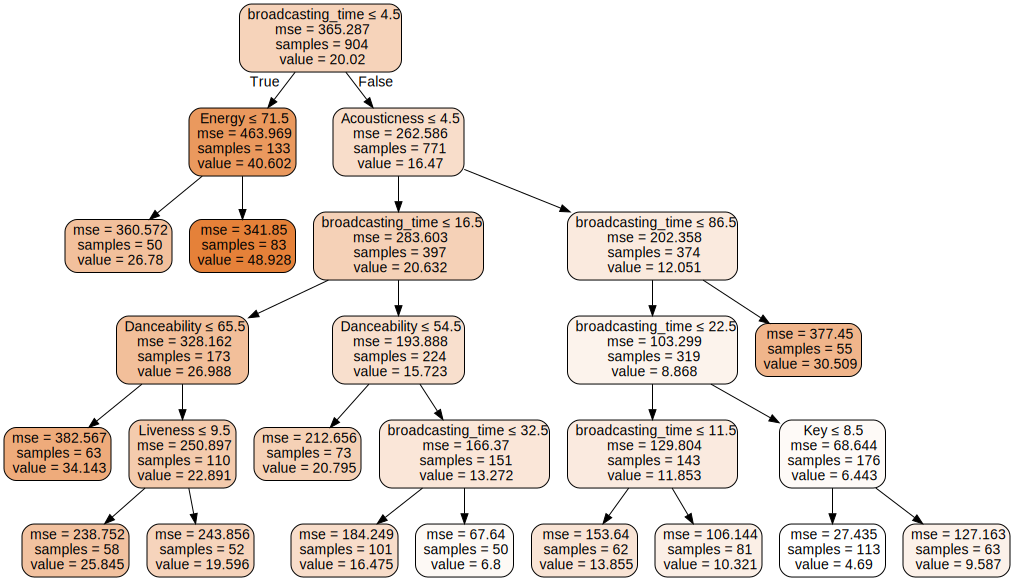

In [119]:
Source(tree.export_graphviz(dtr, filled=True, rounded=True, special_characters=True, feature_names=features.columns.values, class_names=target_values))

Le premier critère de partitionnement se fait sur la variable <i>broadcasting_time</i>, séparant les données en deux groupes distincts de 133 et 771 échantillons. Le modèle laisse à penser que plus une chanson apparaît au sein d'une playlist longtemps, meilleure sera sa position-pic. Les variables <i>Energy</i>, <i>Acousticness</i> et <i>Danceability</i> semblent tout aussi décisives dans ce partionnement. <br> En raison des résultats mitigés obtenus, on ne peut pas conclure davantage. Supprimer certaines variables ou en inclure d'autres aurait peut-être permis d'obtenir de meilleurs résultats, bien qu'ajouter la variable <i>av_position</i> semble, par nature même de la tâche de classification, déraisonnable.

#### <u>Régression linéaire<u>

##### Apprentissage et validation

In [120]:
X_train, X_test, y_train, y_test = train_test_split(features, target_values, test_size=0.2, random_state=2)

In [121]:
rl = LinearRegression()

rl_grid_parameters = {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]}

rl_gs = GridSearchCV(rl, rl_grid_parameters, cv=10, iid=True)
rl_gs.fit(X_train, y_train);

In [122]:
rl = rl_gs.best_estimator_
rl.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

##### Test

In [123]:
r2_score(y_test, rl.predict(X_test))

0.16341732932674924

Les résultats obtenus sont ici encore plus faibles, avec un R2 score de 0.16.

### 3.3 Modèle prédictif de la position pic (attribut binaire)

_Pour la playlist de votre choix ou bien la totalité des playlists, construisez un modèle
de scoring permettant de prédire la position d'une chanson. Évaluez le modèle à l'aide d'une courbe ROC ou lift._

On incluera là encore dans les features la variable <i>broadcasting_time</i>.

In [124]:
features = total[variables]

In [125]:
data_dimension(features)

1130 enregistrements décrits par 11 champs : BPM, Key, Mode, Danceability, Valence, Energy, Acousticness, Instrumentalness, Liveness, Speechiness, broadcasting_time


Les données seront transformées en amont (scaling). Cette mise à l'échelle est nécessaire pour donner à l'ensemble des features la même influence, mais permet aussi de limiter/diminuer la complexité calculatoire.

In [126]:
features_scaled = scale_dataframe(features)

In [127]:
target_values = total['pic_bool']

On cherchera ici à prédire la position pic d'une chanson.

#### <u>Machine à vecteurs de support (SVM), Forêts Aléatoires et K plus proches voisins (KNN)<u>

##### Apprentissage et validation

In [128]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_values, test_size=0.2, random_state=2)

<u>Machines à vecteurs de support (SVM)</u>

In [129]:
clf = SVC(gamma='auto', probability=True)

clf_grid_parameters = {'kernel': ['linear', 'rbf'], 'C': [0.01, 0.1, 0.5, 1, 10, 100]}


clf_gs = GridSearchCV(clf, clf_grid_parameters, cv=10, iid=True);
clf_gs.fit(X_train, y_train);

In [130]:
print(clf_gs.best_params_)
print(clf_gs.best_score_)

{'C': 0.5, 'kernel': 'rbf'}
0.7201327433628318


In [131]:
clf = clf_gs.best_estimator_
clf.fit(X_train, y_train)

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

<u>Forêts aléatoires</u>

In [132]:
rfc = RandomForestClassifier()

rfc_grid_parameters = {'n_estimators':[200, 700], 'max_features':['auto', 'log2', 'sqrt']}

rfc_gs = GridSearchCV(rfc, rfc_grid_parameters, cv=10, iid=True);
rfc_gs.fit(X_train, y_train);

print(rfc_gs.best_params_)
print(rfc_gs.best_score_)

{'max_features': 'auto', 'n_estimators': 200}
0.7466814159292036


In [133]:
rfc = rfc_gs.best_estimator_
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

<u>K plus proches voisins</u>

In [134]:
knn = KNeighborsClassifier()

knn_grid_parameters = {'n_neighbors': np.arange(1, 50)}
knn_gs = GridSearchCV(knn, knn_grid_parameters, cv=10, iid=True)
knn_gs.fit(features_scaled, target_names)

print(knn_gs.best_params_)
print(knn_gs.best_score_)

{'n_neighbors': 39}
0.820353982300885


In [135]:
knn = knn_gs.best_estimator_
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=39, p=2,
           weights='uniform')

##### Test

Scoring à l'aide d'une courbe ROC

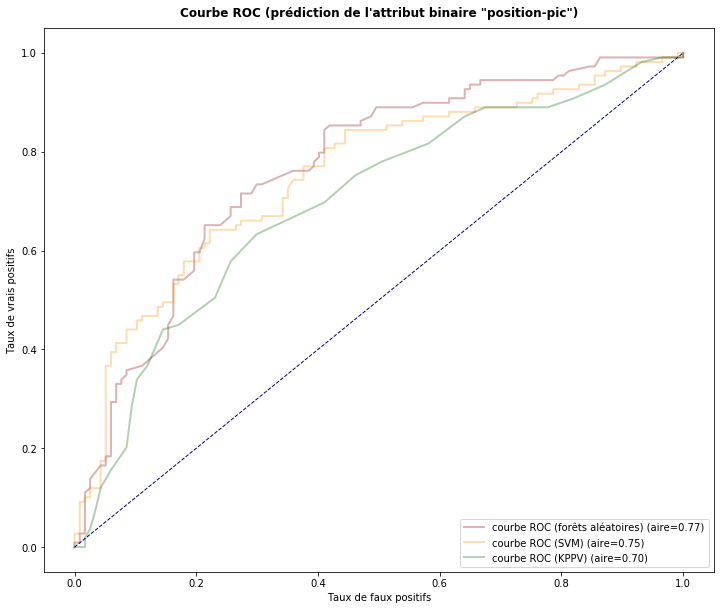

In [136]:
ypred_clf = clf.predict_proba(X_test)
fpr_clf, tpr_clf, thresholds = roc_curve(y_test, ypred_clf[:,1])
roc_auc_clf = auc(fpr_clf, tpr_clf)

ypred_rf = rfc.predict_proba(X_test)
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, ypred_rf[:,1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

ypred_knn= knn.predict_proba(X_test)
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, ypred_knn[:,1])
roc_auc_knn = auc(fpr_knn, tpr_knn)


plt.figure(figsize=(12,10))
plt.plot(fpr_rf, tpr_rf, lw=2, alpha=0.3, color='darkred', label='courbe ROC (forêts aléatoires) (aire=%0.2f)' %roc_auc_rf);
plt.plot(fpr_clf, tpr_clf, lw=2, alpha=0.3, color='darkorange', label='courbe ROC (SVM) (aire=%0.2f)' %roc_auc_clf);
plt.plot(fpr_knn, tpr_knn, lw=2, alpha=0.3, color='darkgreen', label='courbe ROC (KPPV) (aire=%0.2f)' %roc_auc_knn);
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
plt.title('Courbe ROC (prédiction de l\'attribut binaire "position-pic")', y=1.01, fontweight='bold')
plt.xlabel('Taux de faux positifs');
plt.ylabel('Taux de vrais positifs');
plt.legend(loc='lower right');

Les résultats obtenus laissent penser que les forêts aléatoires performent le mieux cette tâche de classification, suivis des SVM, avec une aire respective de 0.77 et 0.75.